This plot will look at the mean amplitudes of the profiles and compare it to other variables to see what is causing the fluctuations. We will use A13 Winter and Summer 2023 data, since we have temperatures for both those seasons

In [2]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    01:03:57 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    01:03:57 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    01:03:57 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44571")
client

<Client: 'tcp://127.0.0.1:44571' processes=4 threads=16, memory=125.80 GiB>

Start by looking at winter

In [4]:
with open('../chirp_processing/A11_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

In [5]:
#with open('../chirp_processing/A13_22W.pickle', 'rb') as handle:
#    winter = pickle.load(handle)

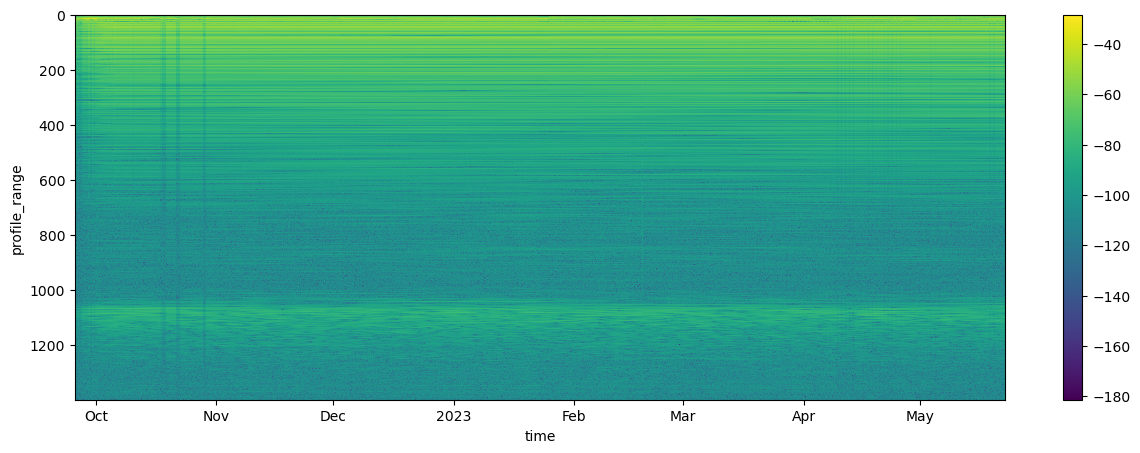

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(winter).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)

In [7]:
time_to_interp = pd.date_range("2022-10-28 0:00", "2022-10-30 0:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')


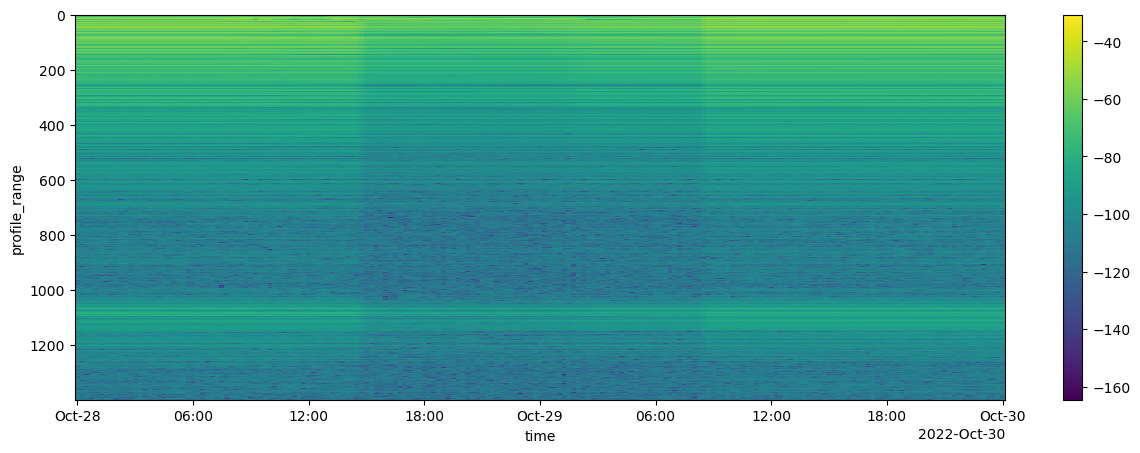

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(interp_profiles).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)

(200.0, 0.0)

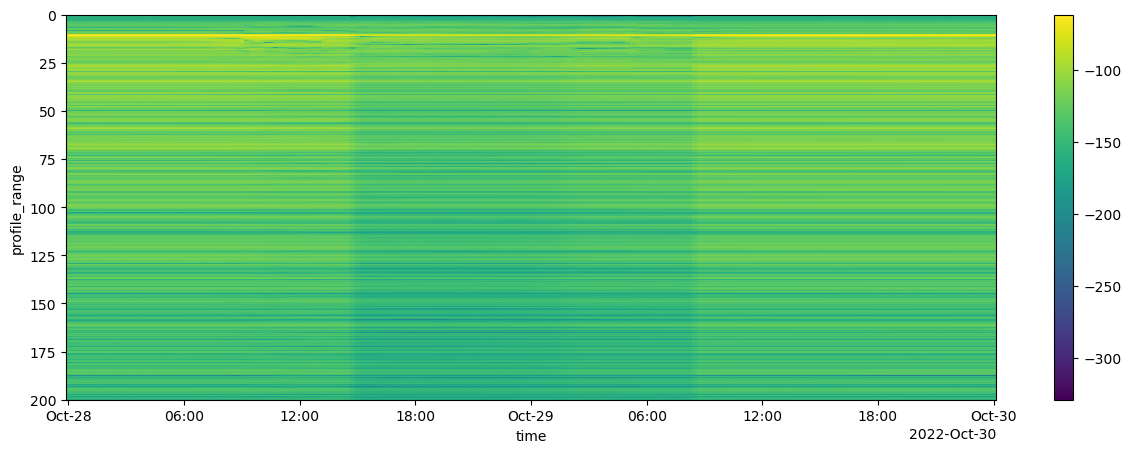

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(abs(interp_profiles)**2).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)
plt.ylim([200,0])

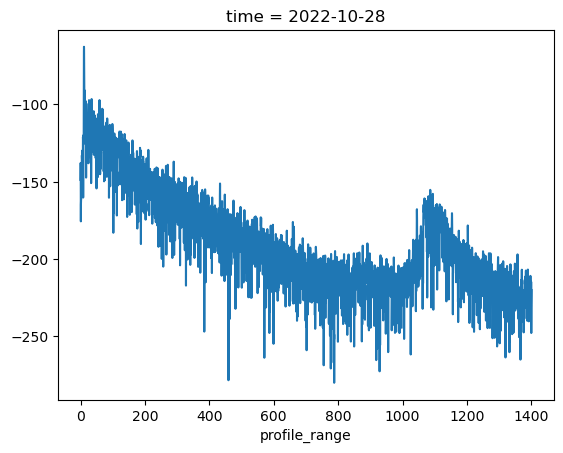

In [10]:
xa.dB(abs(interp_profiles)**2).isel(time=0).plot()


Text(0.5, 1.0, 'Phase')

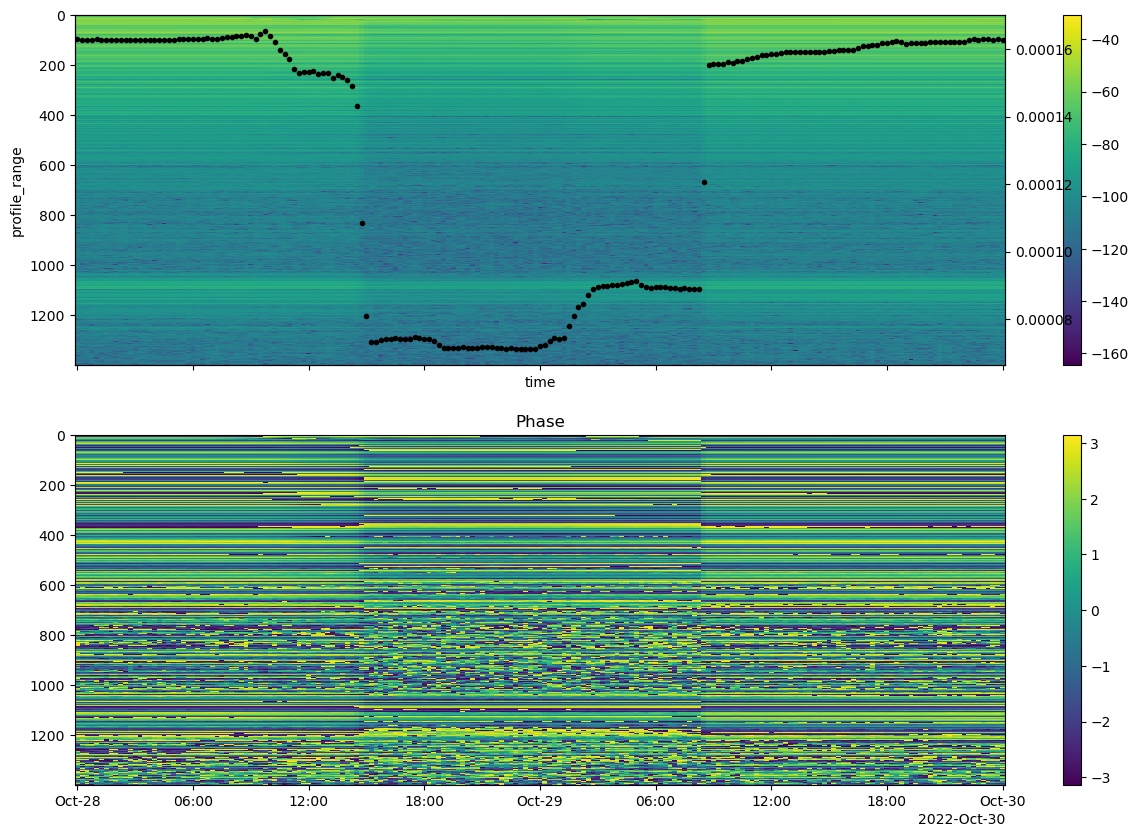

In [11]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
fg=xa.dB(interp_profiles).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
ax1 = axs[0].twinx()
abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')

phi = -np.angle(interp_profiles).astype(float)
im = axs[1].pcolormesh(interp_profiles.time.values,interp_profiles.profile_range.values,phi.T)
axs[1].invert_yaxis()
fig.colorbar(im)
axs[1].set_title('Phase')

In [12]:
def load_temp_csv(file):
    data = pd.read_csv(file)
    times = pd.to_datetime(data['Date-Time (Greenland Standard Time)'])
    times_utc = times + timedelta(hours=2)
    temps = data[data.columns[2]]
    return times_utc,temps

ds_11_w = reload_winter("A101")
voltage = ds_11_w.battery_voltage.interp(time=time_to_interp,method='linear').compute()
winter_time,winter_temp = load_temp_csv('TS08 2023-05-19 11_07_36.csv')
temperature = xr.DataArray(data=winter_temp,dims=["time"],coords=dict(time=winter_time)).interp(time=time_to_interp,method='linear')

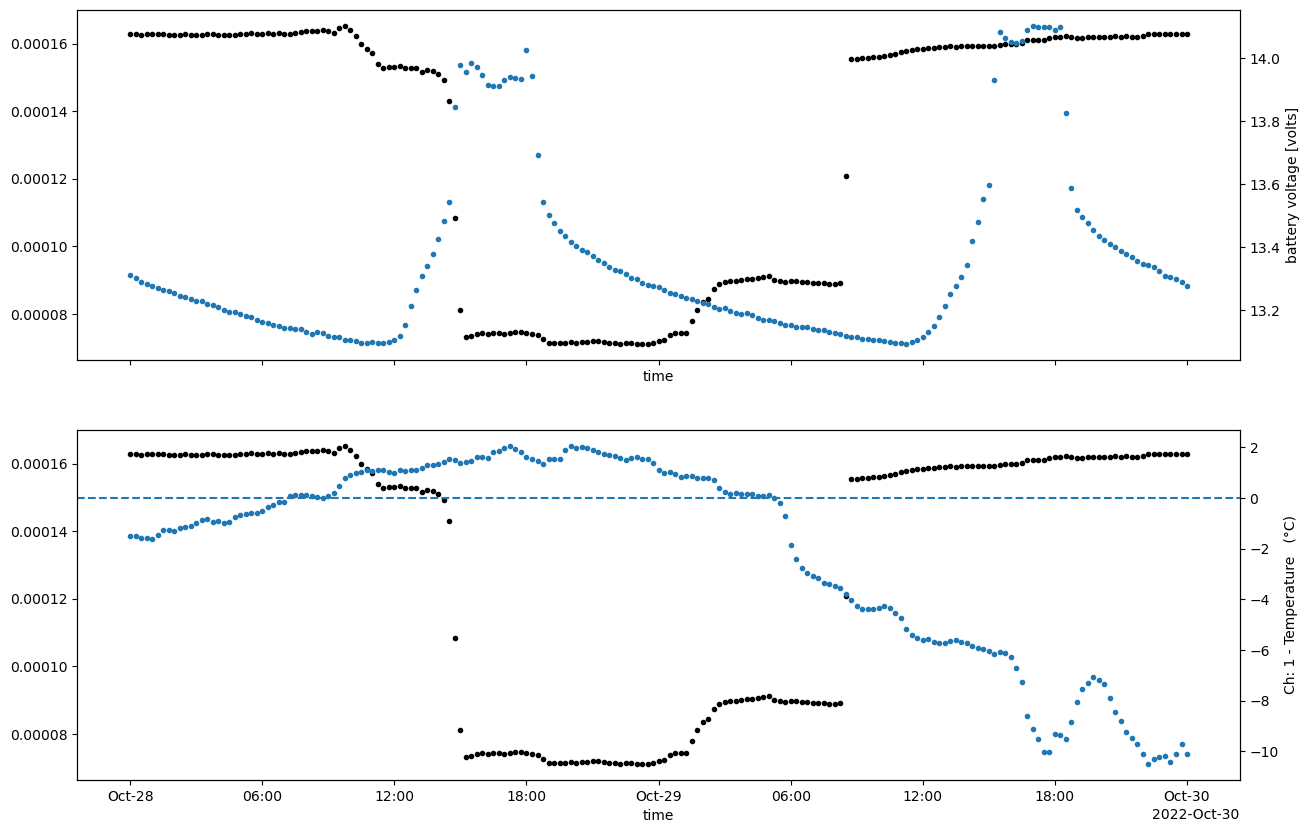

In [13]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
abs(interp_profiles).mean(dim='profile_range').plot(ax=axs[0],color='k',linestyle='None',marker='.')
ax1 = axs[0].twinx()
voltage.plot(ax=ax1,linestyle='None',marker='.')

abs(interp_profiles).mean(dim='profile_range').plot(ax=axs[1],color='k',linestyle='None',marker='.')
ax2 = axs[1].twinx()
temperature.plot(ax=ax2,linestyle='None',marker='.')
ax2.axhline(0,linestyle='--')



Text(0.5, 0, 'Mean profile amplitude')

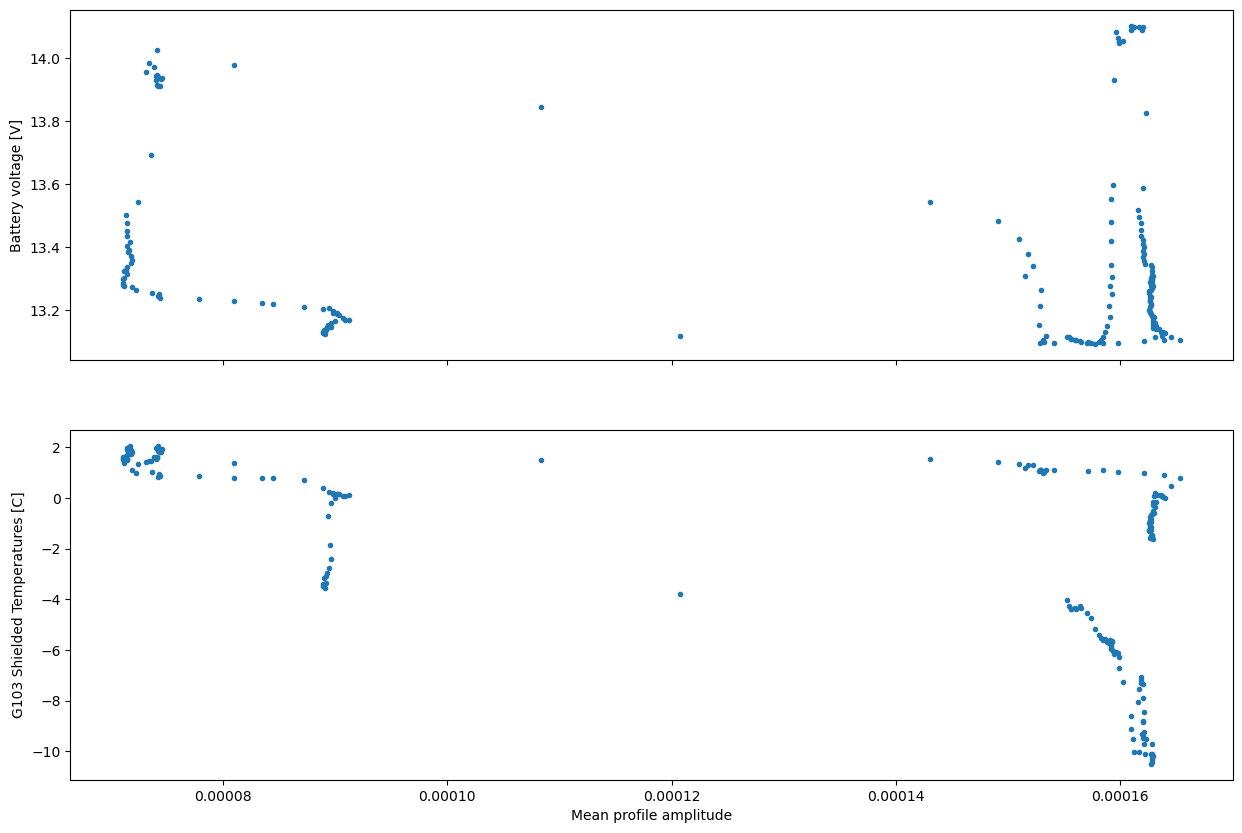

In [14]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)

axs[0].plot(abs(interp_profiles).mean(dim='profile_range').values,voltage.values,linestyle='None',marker='.')
axs[1].plot(abs(interp_profiles).mean(dim='profile_range').values,temperature.values,linestyle='None',marker='.')

axs[0].set_ylabel('Battery voltage [V]')
axs[1].set_ylabel('G103 Shielded Temperatures [C]')
axs[1].set_xlabel('Mean profile amplitude')

In [15]:
# Look at how this affects displacement estimates
def strain_metrics(ds, win_cor, step, lag, noise_floor):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv.where(vv.profile_range <=noise_floor)-vv.where(vv.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    return np.count_nonzero(abs(co)>0.95)/np.count_nonzero(co),np.mean(r2).values,[vv,vv_err,fit,r2,slope_errs]

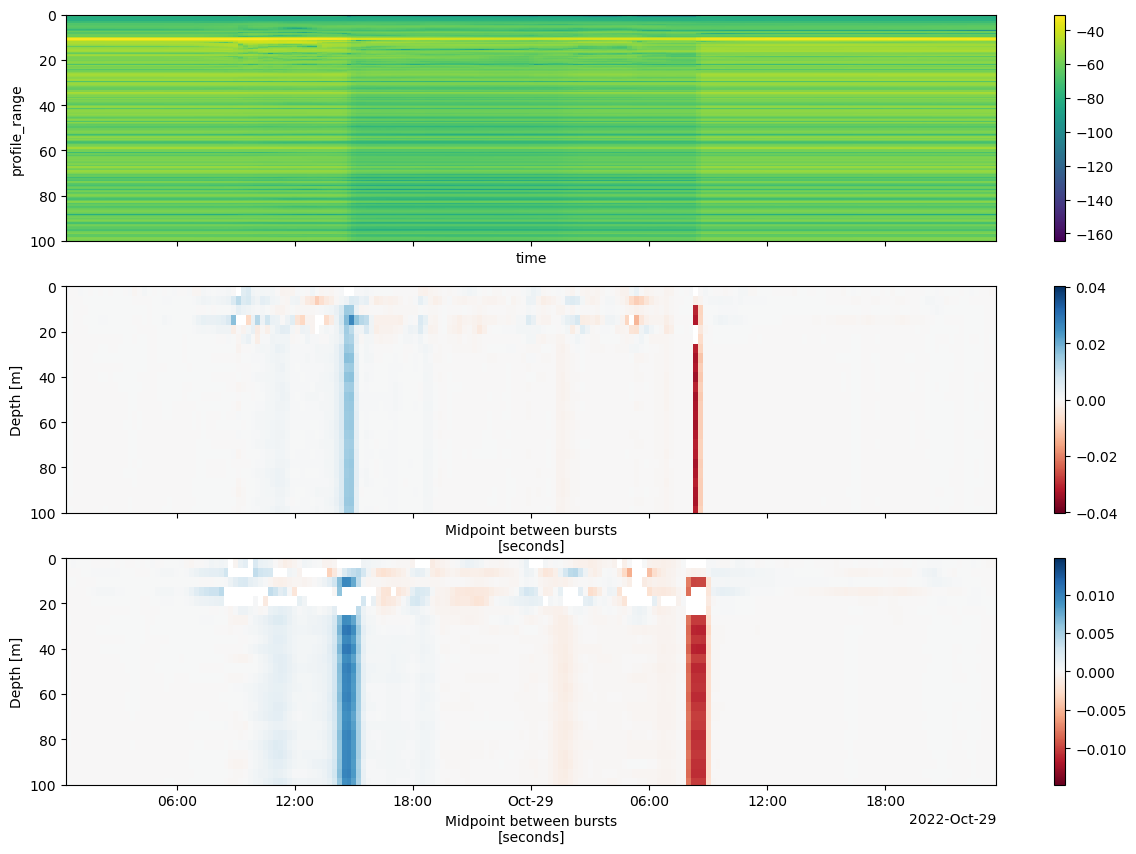

In [16]:
fig, axs = plt.subplots(nrows=3,figsize=(15,10),sharex=True)
xa.dB(interp_profiles).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
axs[0].set_ylim([100,0])
windows = [1,4]
labels = ['15 minutes','1 hour']

for i in range(2):
    count,r2,res = strain_metrics(interp_profiles, 20, 20,windows[i],700)
    disp = res[0]*900/31536000
    disp.plot(ax=axs[1+i],x='time',cmap='RdBu')#,vmin=-10,vmax=10)
    axs[i+1].invert_yaxis()
    axs[i+1].set_ylim([100,0])

Text(0, 0.5, 'depth [m]')

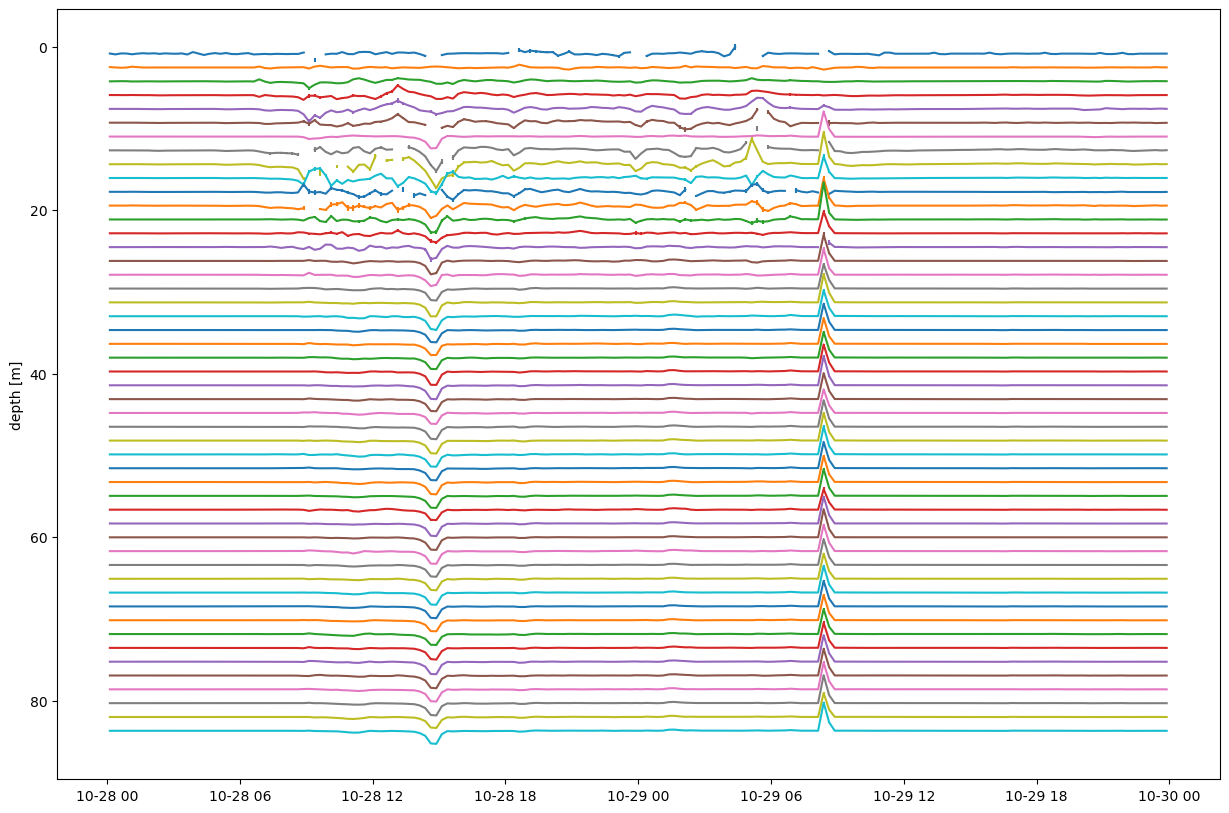

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
count,r2,res = strain_metrics(interp_profiles, 8, 8,1,700)

for i in range(50):
    disp = (res[0]*900/31536000).isel(profile_range=[i])
    disp_err = (res[1]*900/31536000).isel(profile_range=i)*100
    disp_adjust = (disp.profile_range + 100*disp).isel(profile_range = 0)
    ax.errorbar(disp_adjust.time.values,disp_adjust,disp_err)#,linestyle='None',marker='.')
    #(disp.profile_range + 100*disp).plot()
    #disp.plot(ax=axs[1+i],x='time',cmap='RdBu')#,vmin=-10,vmax=10)
ax.invert_yaxis()
ax.set_ylabel('depth [m]')
    #axs[i+1].set_ylim([100,0])

In [88]:
disp.time.values

array(['2022-10-28T00:07:30.000000000', '2022-10-28T00:22:30.000000000',
       '2022-10-28T00:37:30.000000000', '2022-10-28T00:52:30.000000000',
       '2022-10-28T01:07:30.000000000', '2022-10-28T01:22:30.000000000',
       '2022-10-28T01:37:30.000000000', '2022-10-28T01:52:30.000000000',
       '2022-10-28T02:07:30.000000000', '2022-10-28T02:22:30.000000000',
       '2022-10-28T02:37:30.000000000', '2022-10-28T02:52:30.000000000',
       '2022-10-28T03:07:30.000000000', '2022-10-28T03:22:30.000000000',
       '2022-10-28T03:37:30.000000000', '2022-10-28T03:52:30.000000000',
       '2022-10-28T04:07:30.000000000', '2022-10-28T04:22:30.000000000',
       '2022-10-28T04:37:30.000000000', '2022-10-28T04:52:30.000000000',
       '2022-10-28T05:07:30.000000000', '2022-10-28T05:22:30.000000000',
       '2022-10-28T05:37:30.000000000', '2022-10-28T05:52:30.000000000',
       '2022-10-28T06:07:30.000000000', '2022-10-28T06:22:30.000000000',
       '2022-10-28T06:37:30.000000000', '2022-10-28

In [80]:
disp

<xarray.DataArray (time: 192, profile_range: 1)> Size: 2kB
array([[-2.58843639e-06],
       [ 4.04313618e-06],
       [ 5.26041574e-06],
       [-9.94062507e-06],
       [-3.45520087e-05],
       [-3.51765446e-05],
       [-1.72379914e-05],
       [-7.56179221e-06],
       [ 3.85691291e-06],
       [ 9.41898184e-06],
       [-8.25885524e-07],
       [ 6.56681836e-07],
       [ 4.43037881e-06],
       [ 3.99449060e-06],
       [ 1.05136099e-05],
       [ 6.59680273e-06],
       [-1.92212080e-06],
       [-4.79693564e-06],
       [-1.50040278e-05],
       [-1.63353521e-05],
...
       [-1.39184184e-05],
       [ 2.56280362e-06],
       [-4.19263573e-05],
       [-3.24016923e-05],
       [ 2.59048555e-05],
       [ 5.88845874e-05],
       [ 3.60719011e-06],
       [ 7.17584442e-05],
       [ 2.87894708e-05],
       [-6.40821181e-06],
       [-5.49990654e-05],
       [-2.35185050e-05],
       [ 6.46345028e-05],
       [ 3.72074675e-05],
       [-8.70788554e-06],
       [-4.44466256e-06],
       [-3.77172975e-05],
       [-5.74342353e-05],
       [-1.15188106e-05],
       [ 1.19905634e-05]])
Coordinates:
  * time           (time) datetime64[ns] 2kB 2022-10-28T00:07:30 ... 2022-10-...
  * profile_range  (profile_range) float64 8B 40.16

Text(0, 0.5, 'Mean profile amplitude')

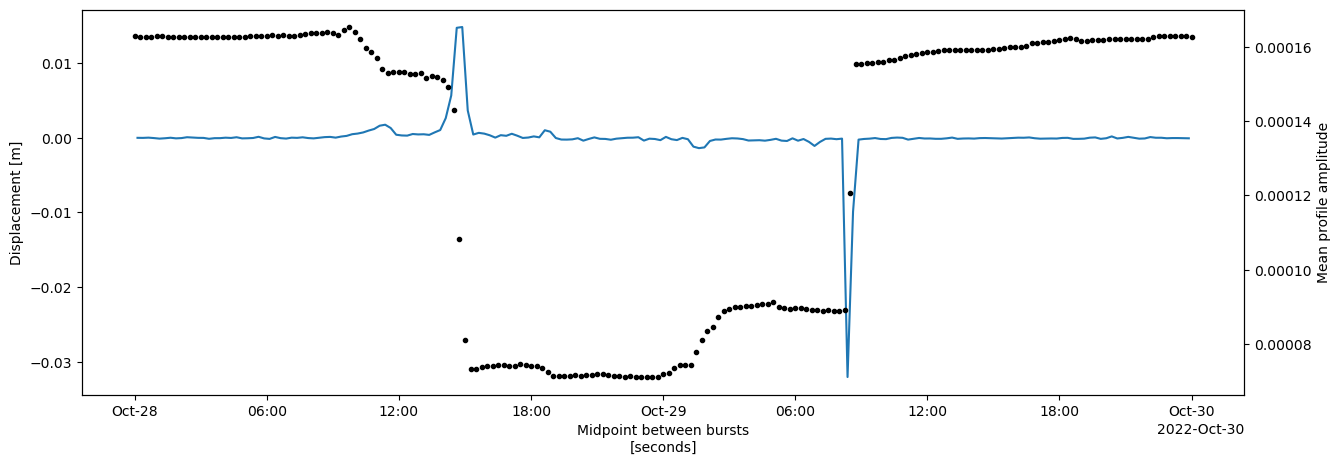

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
count,r2,res = strain_metrics(interp_profiles, 70, 70,1,700)
disp = res[0]*900/31536000
disp.where(disp.profile_range <600).mean(dim='profile_range').plot(ax=ax)
ax1 = ax.twinx()
abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')
ax.set_ylabel('Displacement [m]')
ax1.set_ylabel('Mean profile amplitude')

Now let's look at the chirp sequence

In [14]:
ds_11_w = reload_winter("A101")
time_to_interp_jump = pd.date_range("2022-10-28 12:00", "2022-10-28 18:00", freq="15min")
time_to_interp_fall = pd.date_range("2022-10-29 6:00", "2022-10-29 12:00", freq="15min")

chirps_jump = ds_11_w.chirp.isel(attenuator_setting_pair=0).interp(time=time_to_interp_jump,method='linear').compute()
chirps_fall = ds_11_w.chirp.isel(attenuator_setting_pair=0).interp(time=time_to_interp_fall,method='linear').compute()

Text(0.5, 0, 'chirp time [ns]')

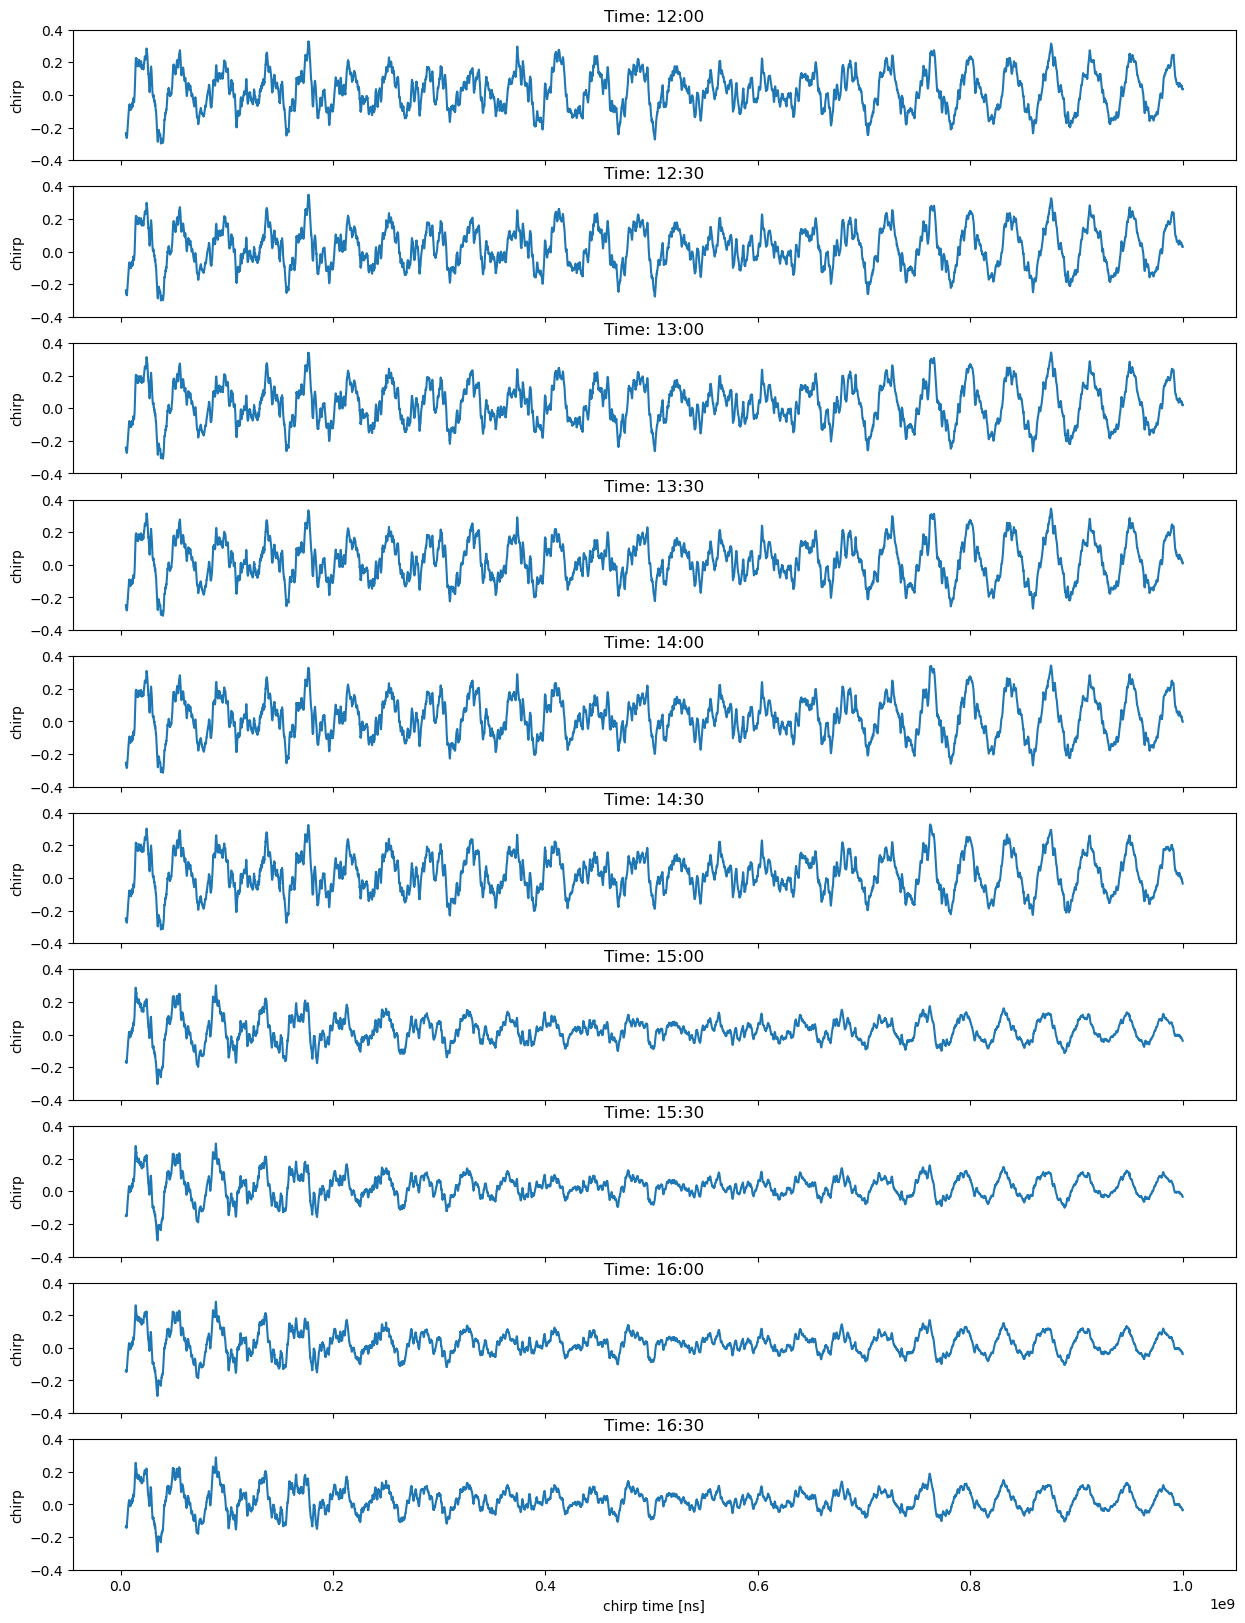

In [79]:
fig, axs = plt.subplots(nrows=10,figsize=(15,20),sharex=True)
for i in range(10):
    chirp = chirps_jump.isel(time= [i*2],chirp_time=range(200,39998)).mean(dim='chirp_num')
    chirp.plot(ax=axs[i])
    axs[i].set_title(f'Time: {str(chirp.time.values[0])[11:16]}')
    axs[i].set_xlabel('')
    axs[i].set_ylim([-0.4,0.4])
axs[-1].set_xlabel('chirp time [ns]')


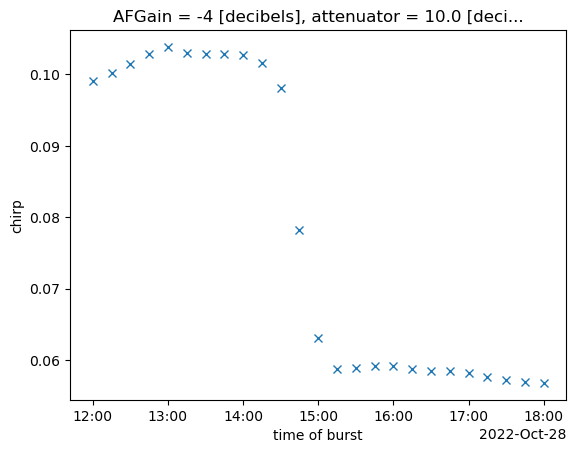

In [80]:
abs(chirps_jump.isel(chirp_time=range(200,39998))).mean(dim=['chirp_time','chirp_num']).plot(x='time',linestyle='None',marker='x',label='mean chirp amplitude')


In [81]:
clip_threshold = 1.2
min_chirps = 5
bad_chirps =  chirps_jump.where(abs(chirps_jump) > clip_threshold)
good_bursts = bad_chirps.max(dim='chirp_time').count(dim='chirp_num') <= 20-min_chirps
chirps = chirps_jump.where(good_bursts)
chirps = chirps.where(abs(chirps).max(dim='chirp_time')<clip_threshold).isel(chirp_time=range(200,39998))

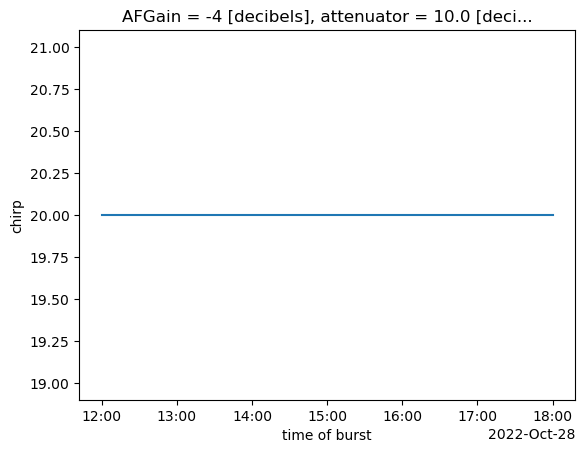

In [82]:
chirps.mean(dim='chirp_time').count(dim='chirp_num').plot()

In [23]:
chirps = ds_11_w.isel(attenuator_setting_pair=0,chirp_time=range(200,39998)).chirp
bad_chirps =  chirps.where(abs(chirps) > clip_threshold)
good_bursts = bad_chirps.max(dim='chirp_time').count(dim='chirp_num') <= 20-min_chirps
chirps = chirps.where(good_bursts)
chirps = chirps.where(abs(chirps).max(dim='chirp_time')<clip_threshold)

In [24]:
to_plot = chirps.mean(dim='chirp_time').count(dim='chirp_num').compute()


In [25]:
to_plot

<xarray.DataArray 'chirp' (time: 22956)> Size: 184kB
array([20, 20, 20, ..., 20, 20, 20])
Coordinates:
    AFGain        int64 8B -4
    attenuator    float64 8B 10.0
    burst_number  (time) int64 184kB 0 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49 50
    filename      (time) <U89 8MB 'ldeo-glaciology/GL_apres_2022/A101/winter2...
  * time          (time) datetime64[ns] 184kB 2022-09-25T15:29:31 ... 2023-05...

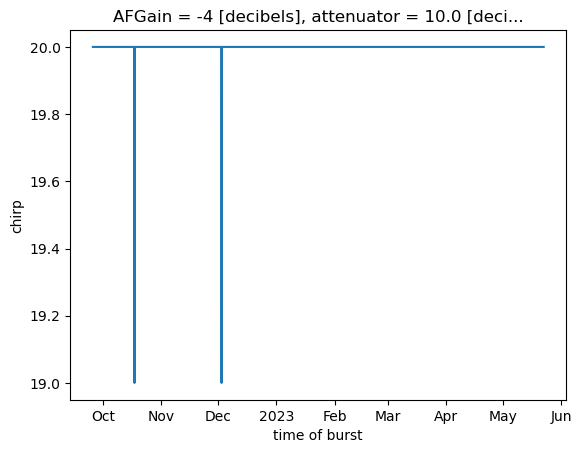

In [26]:
to_plot.plot()

At least in winter, no effect due to reduction in chirps

In [28]:
chirps_jump

<xarray.DataArray 'chirp' (time: 25, chirp_time: 40001, chirp_num: 20)> Size: 160MB
array([[[ 1.90964593e-02,  1.76452637e-02, -1.23993768e-02, ...,
          1.89717611e-04, -1.93595039e-02,  3.82156372e-03],
        [-2.41611905e-02, -2.53517151e-02, -3.17850749e-02, ...,
         -4.09696791e-02, -4.92294312e-02, -3.50067986e-02],
        [-1.68826718e-01, -2.06162601e-01, -1.35368178e-01, ...,
         -2.23572286e-01, -1.93310038e-01, -1.65110609e-01],
        ...,
        [ 3.12911140e-02,  3.72628106e-02,  3.69583130e-02, ...,
          3.71128506e-02,  3.55091519e-02,  3.75938416e-02],
        [ 1.26508925e-02,  5.83691067e-03,  6.73039754e-03, ...,
          1.29324171e-02,  1.29625109e-02,  1.63412306e-02],
        [-9.01965162e-01, -9.08442010e-01, -9.07007345e-01, ...,
         -9.03464678e-01, -9.02905867e-01, -9.00436995e-01]],

       [[ 2.28732639e-02,  3.64490085e-03, -1.08960470e-02, ...,
         -1.45300971e-02, -2.27059258e-02, -3.97889879e-03],
        [-8.99598863e-03, -3.43112522e-02, -4.09027100e-02, ...,
         -5.45146518e-02, -4.49684143e-02, -5.12001885e-02],
        [-1.29103004e-01, -1.93752797e-01, -1.50797017e-01, ...,
         -2.21546512e-01, -1.47625478e-01, -2.07001326e-01],
...
        [-3.50886027e-02, -3.00096300e-02, -3.17765978e-02, ...,
         -3.25676812e-02, -2.85780165e-02, -2.82111274e-02],
        [-2.75061713e-02, -4.52721490e-02, -4.61610582e-02, ...,
         -2.61722141e-02, -2.11232503e-02, -2.30363634e-02],
        [-4.03467814e-02, -7.88162231e-02, -6.14546034e-02, ...,
         -3.88707479e-02, -2.57729424e-02, -4.60537381e-02]],

       [[ 7.95545872e-02,  2.04160245e-02,  1.76282706e-03, ...,
          2.65573510e-02,  2.75805973e-02,  1.59350156e-02],
        [ 3.74406655e-02,  3.56195257e-03, -3.13589962e-02, ...,
          1.11701730e-03,  1.88377145e-02, -3.68025860e-04],
        [-8.53991403e-02, -8.47489613e-02, -1.33586497e-01, ...,
         -1.06851687e-01, -4.00007139e-02, -6.35496635e-02],
        ...,
        [-3.00596464e-02, -3.51009285e-02, -3.37071356e-02, ...,
         -3.16939165e-02, -2.84652038e-02, -3.00055348e-02],
        [-3.67325098e-02, -3.34962349e-02, -3.25107995e-02, ...,
         -3.65831148e-02, -3.37143617e-02, -3.49132185e-02],
        [-7.97668323e-02, -9.12556249e-02, -6.75077060e-02, ...,
         -7.63638534e-02, -6.54343256e-02, -6.98620632e-02]]])
Coordinates:
    AFGain        int64 8B -4
    attenuator    float64 8B 10.0
    burst_number  (time) float64 200B 51.65 52.65 53.65 ... 73.65 74.65 75.64
  * chirp_num     (chirp_num) int64 160B 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * chirp_time    (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
  * time          (time) datetime64[ns] 200B 2022-10-28T12:00:00 ... 2022-10-...
    filename      (time) <U89 9kB 'ldeo-glaciology/GL_apres_2022/A101/winter2...
Attributes:
    description:  voltage from the analog-to-digital converter after the rece...
    long_name:    de-ramped chirp
    units:        volts

Text(0.5, 0, 'chirp number [ns]')

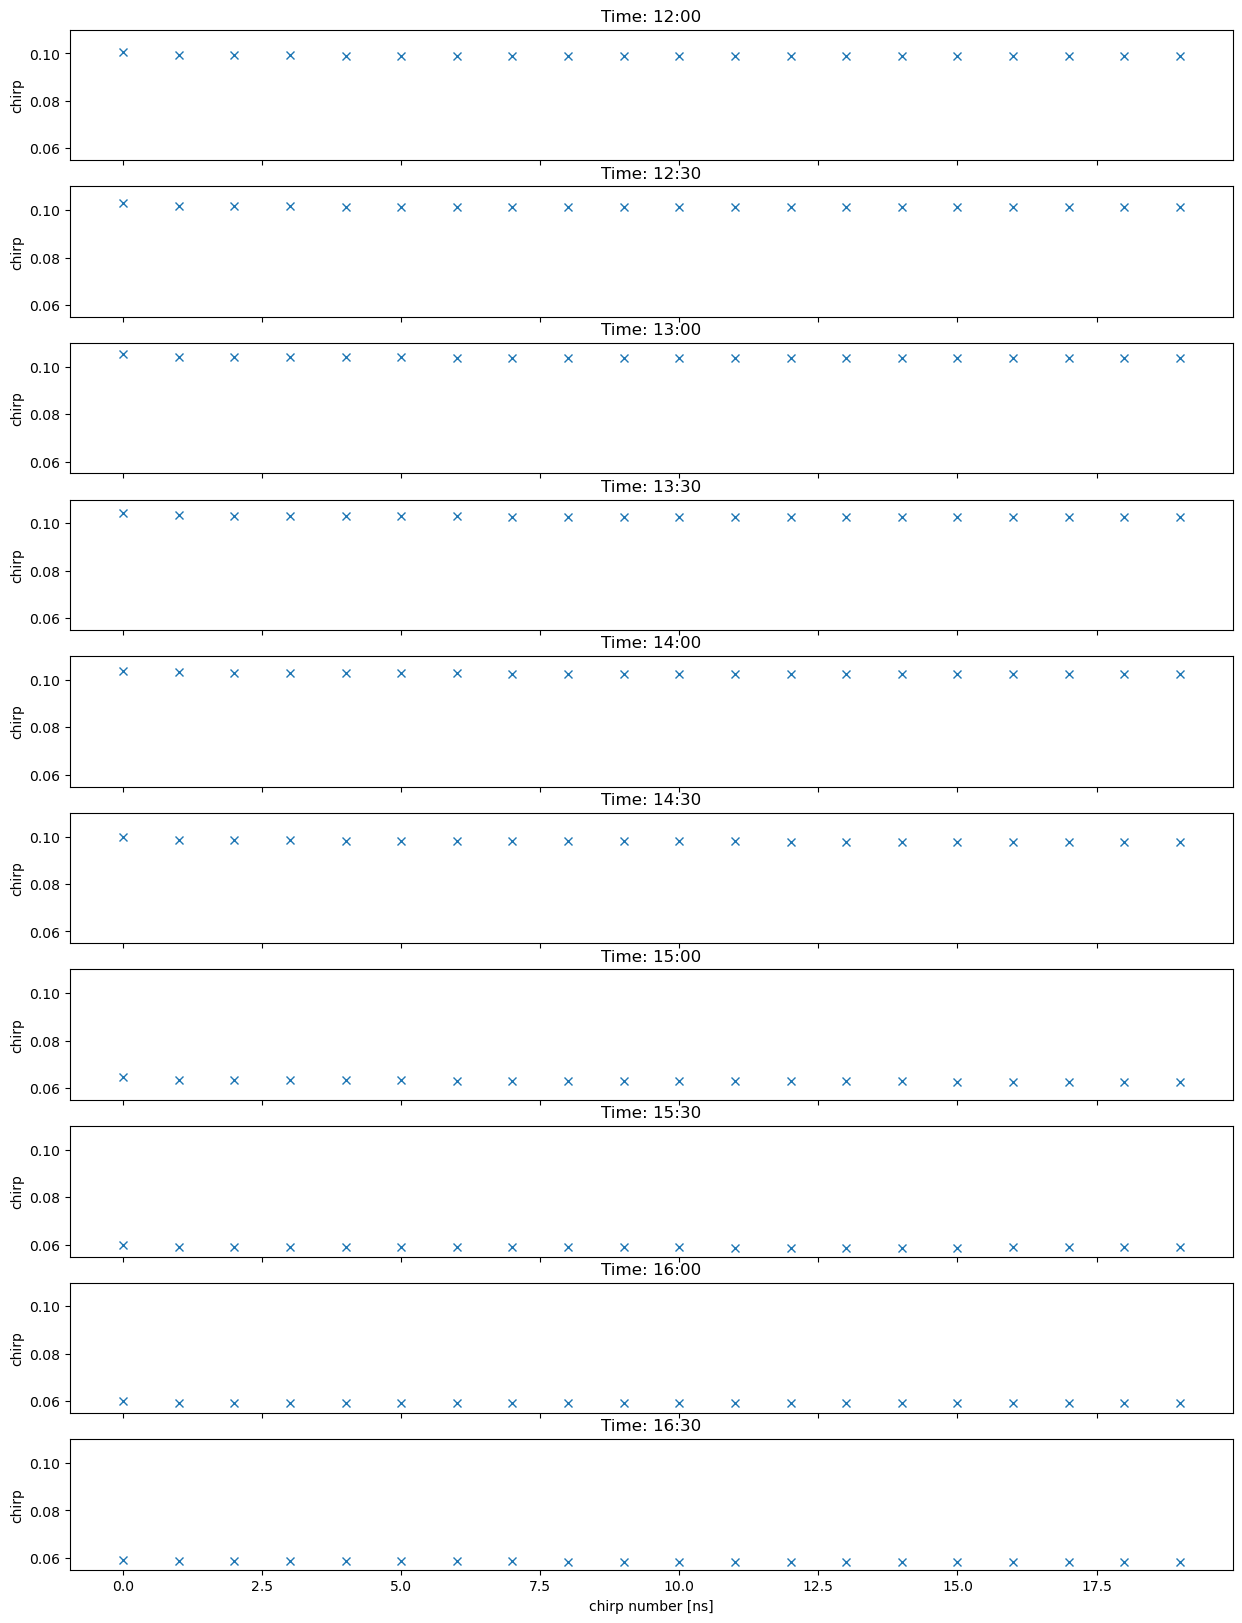

In [43]:
fig, axs = plt.subplots(nrows=10,figsize=(15,20),sharex=True)
for i in range(10):
    chirp = abs(chirps_jump.isel(time= [i*2],chirp_time=range(200,39998))).mean(dim='chirp_time')
    chirp.plot(ax=axs[i],linestyle='None',marker='x')
    axs[i].set_title(f'Time: {str(chirp.time.values[0])[11:16]}')
    axs[i].set_xlabel('')
    axs[i].set_ylim([0.055,0.11])
axs[-1].set_xlabel('chirp number [ns]')


Now look at transition back

Text(0.5, 0, 'chirp time [ns]')

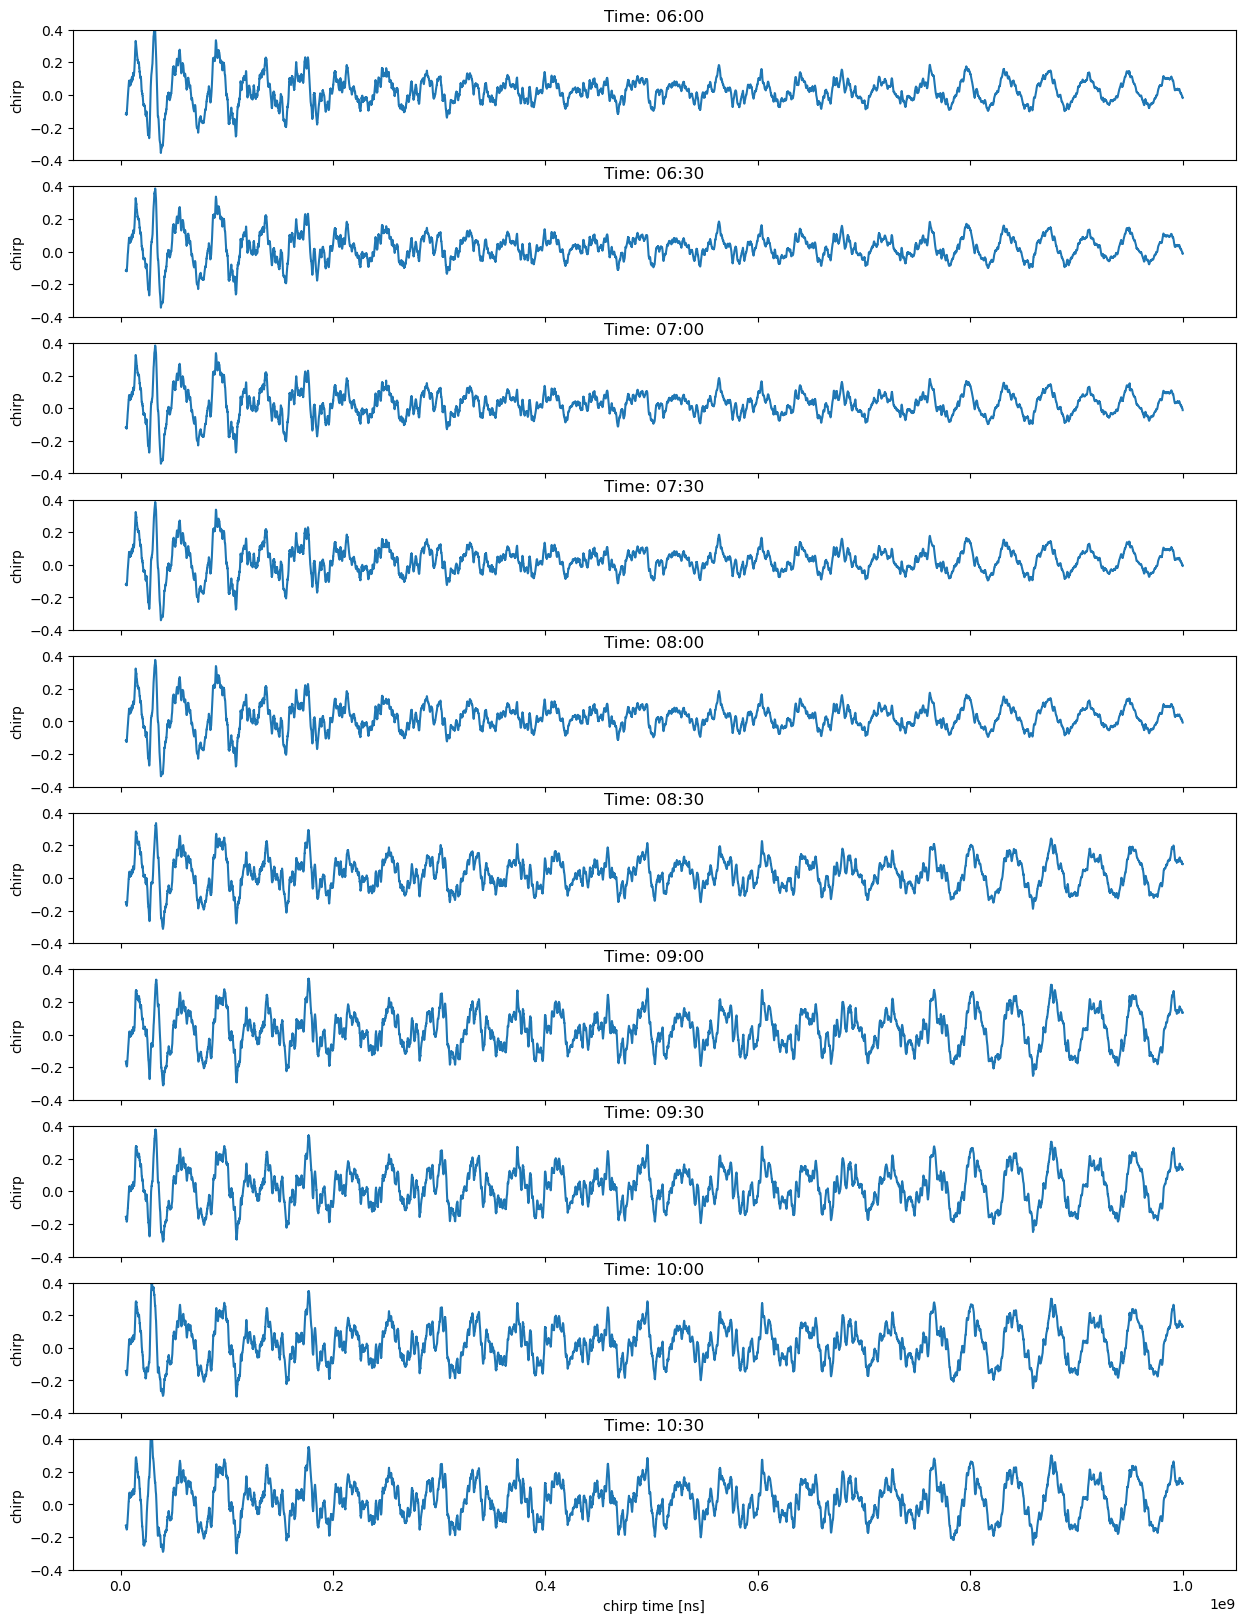

In [40]:
fig, axs = plt.subplots(nrows=10,figsize=(15,20),sharex=True)
for i in range(10):
    chirp = chirps_fall.isel(time= [i*2],chirp_time=range(200,39998)).mean(dim='chirp_num')
    chirp.plot(ax=axs[i])
    axs[i].set_title(f'Time: {str(chirp.time.values[0])[11:16]}')
    axs[i].set_xlabel('')
    axs[i].set_ylim([-0.4,0.4])
axs[-1].set_xlabel('chirp time [ns]')


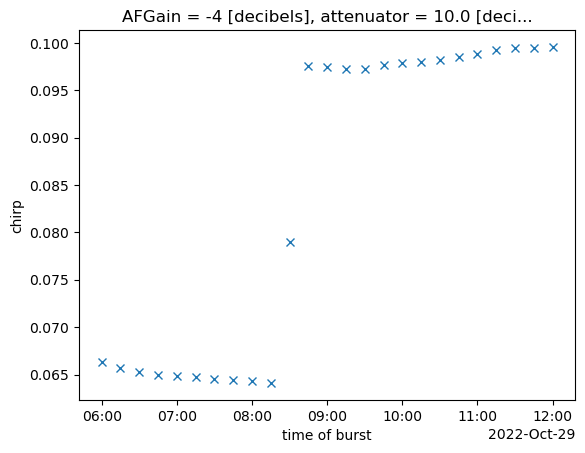

In [41]:
abs(chirps_fall.isel(chirp_time=range(200,39998))).mean(dim=['chirp_time','chirp_num']).plot(x='time',linestyle='None',marker='x',label='mean chirp amplitude')


Text(0.5, 0, 'chirp number [ns]')

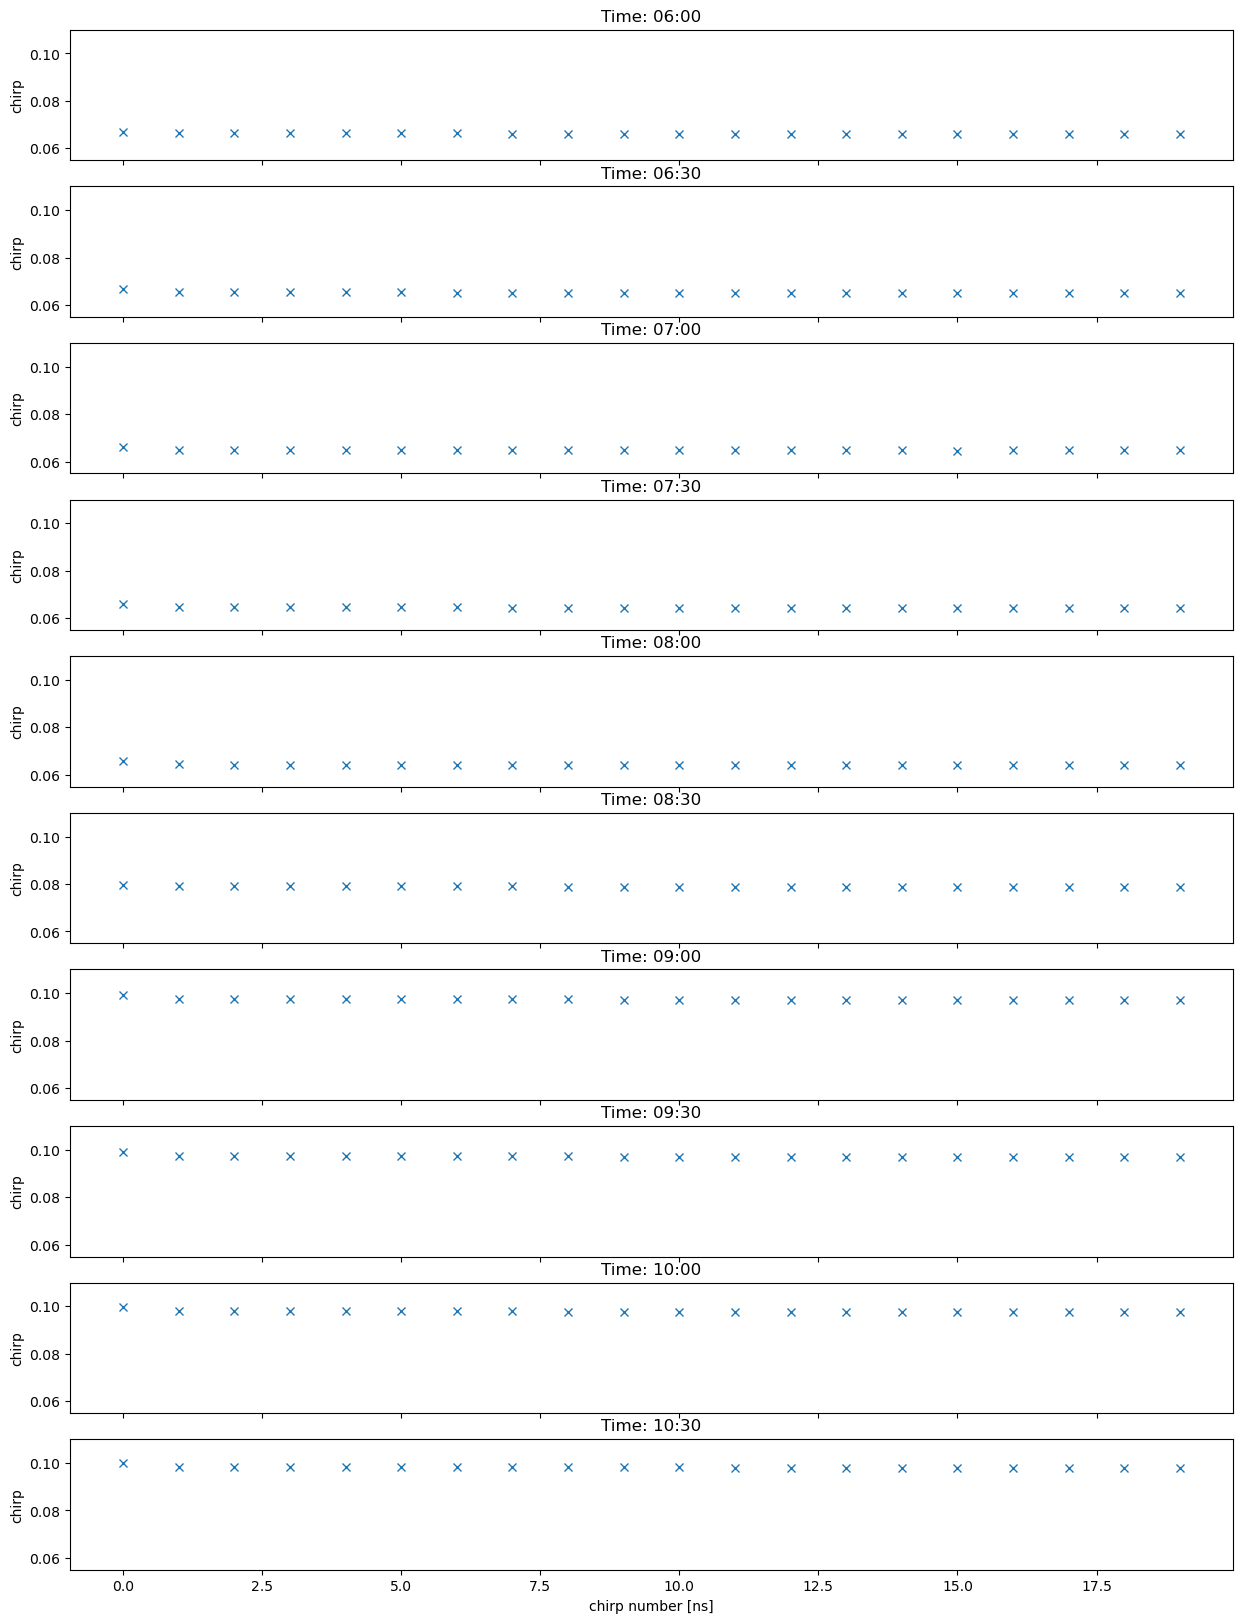

In [44]:
fig, axs = plt.subplots(nrows=10,figsize=(15,20),sharex=True)
for i in range(10):
    chirp = abs(chirps_fall.isel(time= [i*2],chirp_time=range(200,39998))).mean(dim='chirp_time')
    chirp.plot(ax=axs[i],linestyle='None',marker='x')
    axs[i].set_title(f'Time: {str(chirp.time.values[0])[11:16]}')
    axs[i].set_xlabel('')
    axs[i].set_ylim([0.055,0.11])
axs[-1].set_xlabel('chirp number [ns]')


Now let's look at during the diurnal variations

In [20]:
time_to_interp = pd.date_range("2023-04-10 6:00", "2023-04-12 6:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')


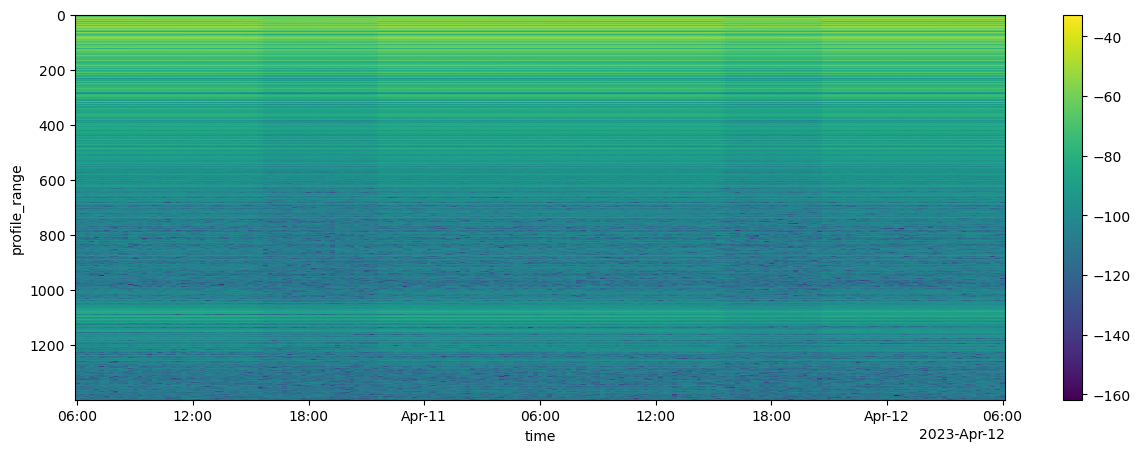

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(interp_profiles).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)

(200.0, 0.0)

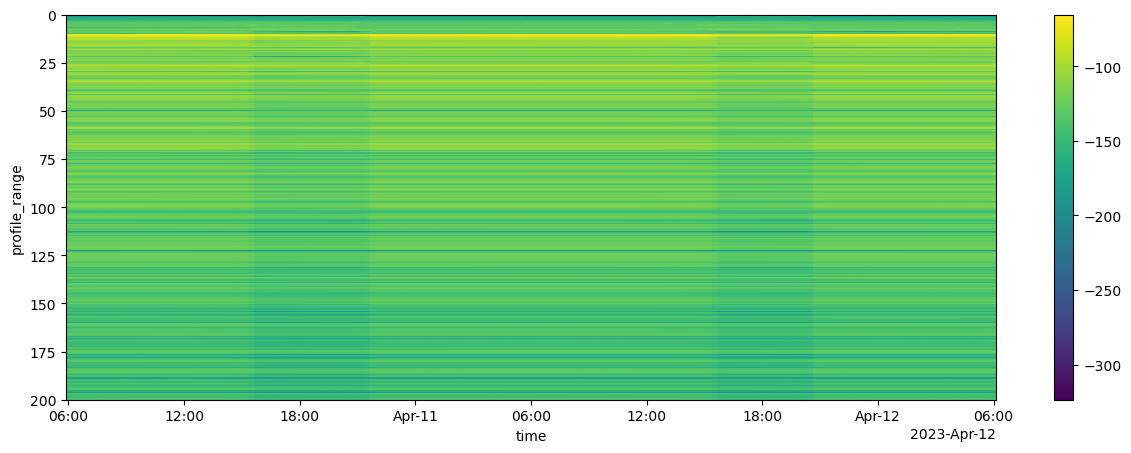

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(abs(interp_profiles)**2).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)
plt.ylim([200,0])

Text(0.5, 1.0, 'Phase')

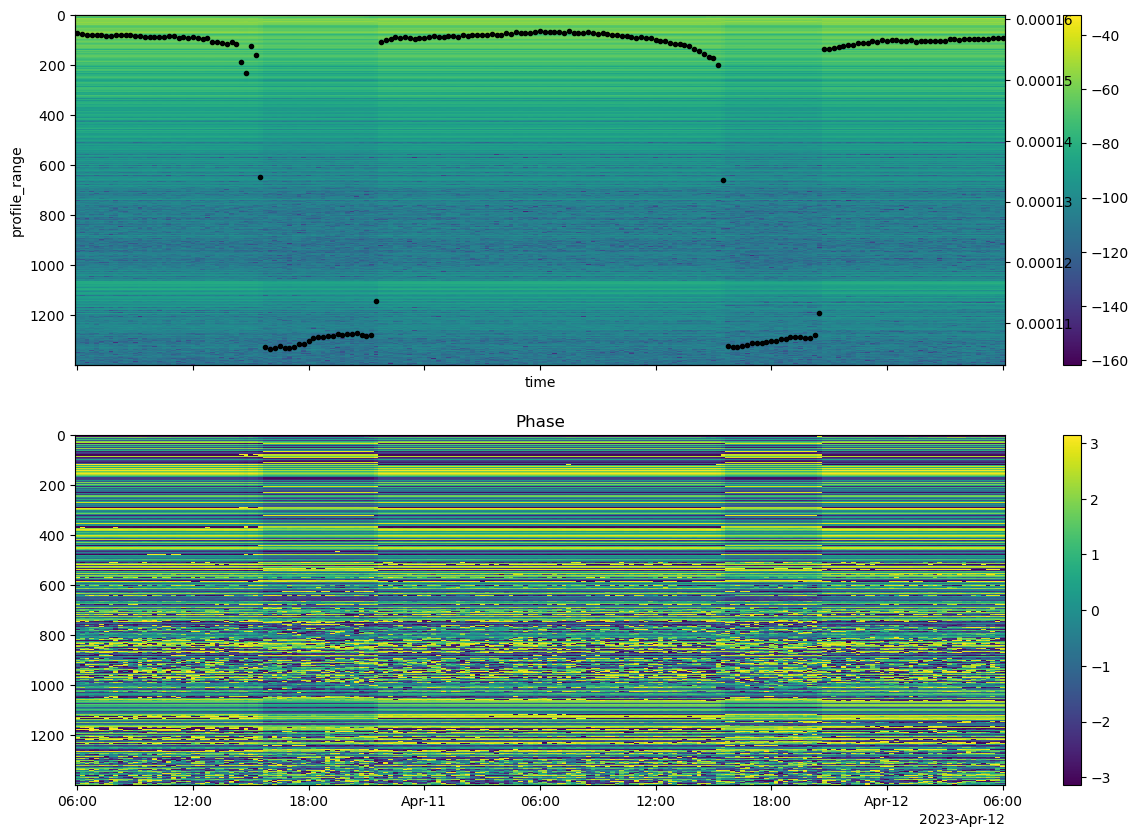

In [23]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
fg=xa.dB(interp_profiles).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
ax1 = axs[0].twinx()
abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')

phi = -np.angle(interp_profiles).astype(float)
im = axs[1].pcolormesh(interp_profiles.time.values,interp_profiles.profile_range.values,phi.T)
axs[1].invert_yaxis()
fig.colorbar(im)
axs[1].set_title('Phase')

In [24]:
voltage = ds_11_w.battery_voltage.interp(time=time_to_interp,method='linear').compute()
winter_time,winter_temp = load_temp_csv('TS08 2023-05-19 11_07_36.csv')
temperature = xr.DataArray(data=winter_temp,dims=["time"],coords=dict(time=winter_time)).interp(time=time_to_interp,method='linear')

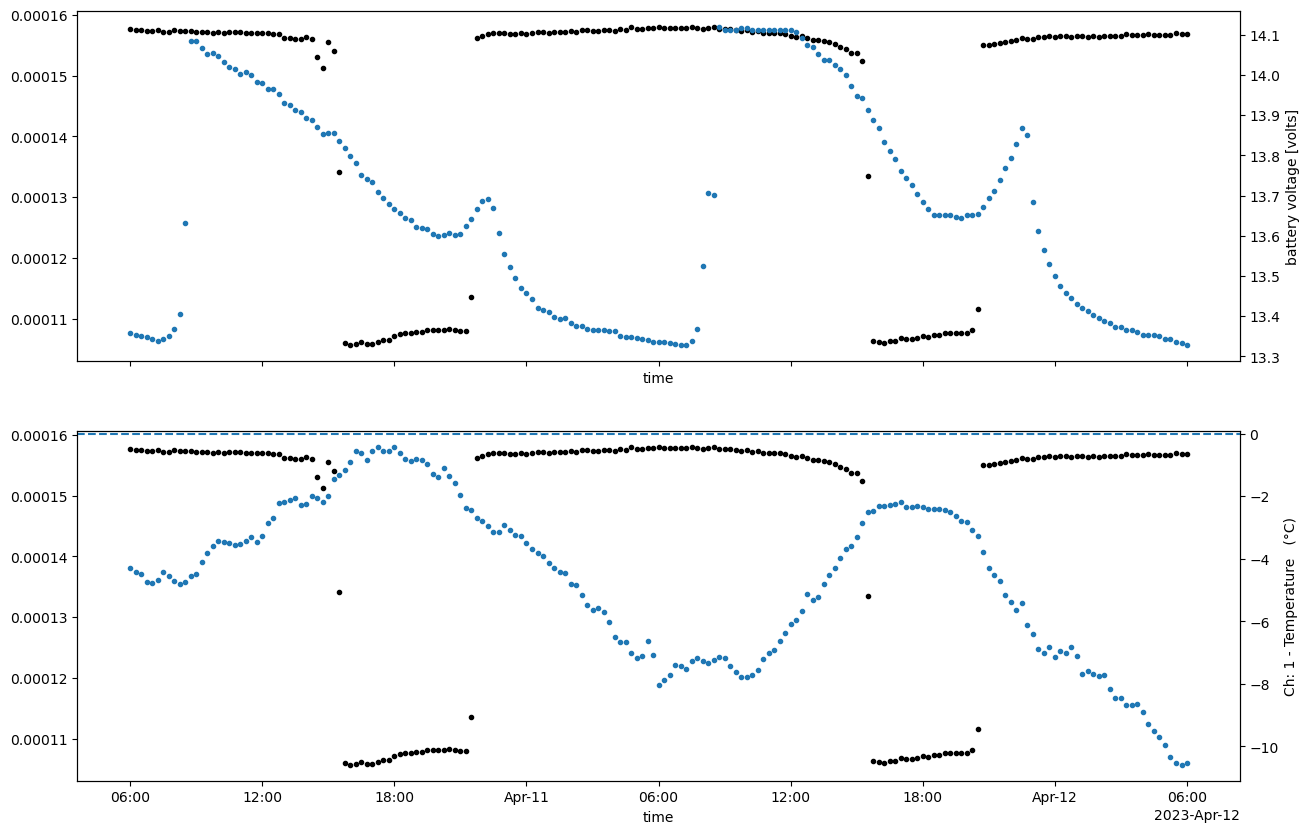

In [25]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
abs(interp_profiles).mean(dim='profile_range').plot(ax=axs[0],color='k',linestyle='None',marker='.')
ax1 = axs[0].twinx()
voltage.plot(ax=ax1,linestyle='None',marker='.')

abs(interp_profiles).mean(dim='profile_range').plot(ax=axs[1],color='k',linestyle='None',marker='.')
ax2 = axs[1].twinx()
temperature.plot(ax=ax2,linestyle='None',marker='.')
ax2.axhline(0,linestyle='--')



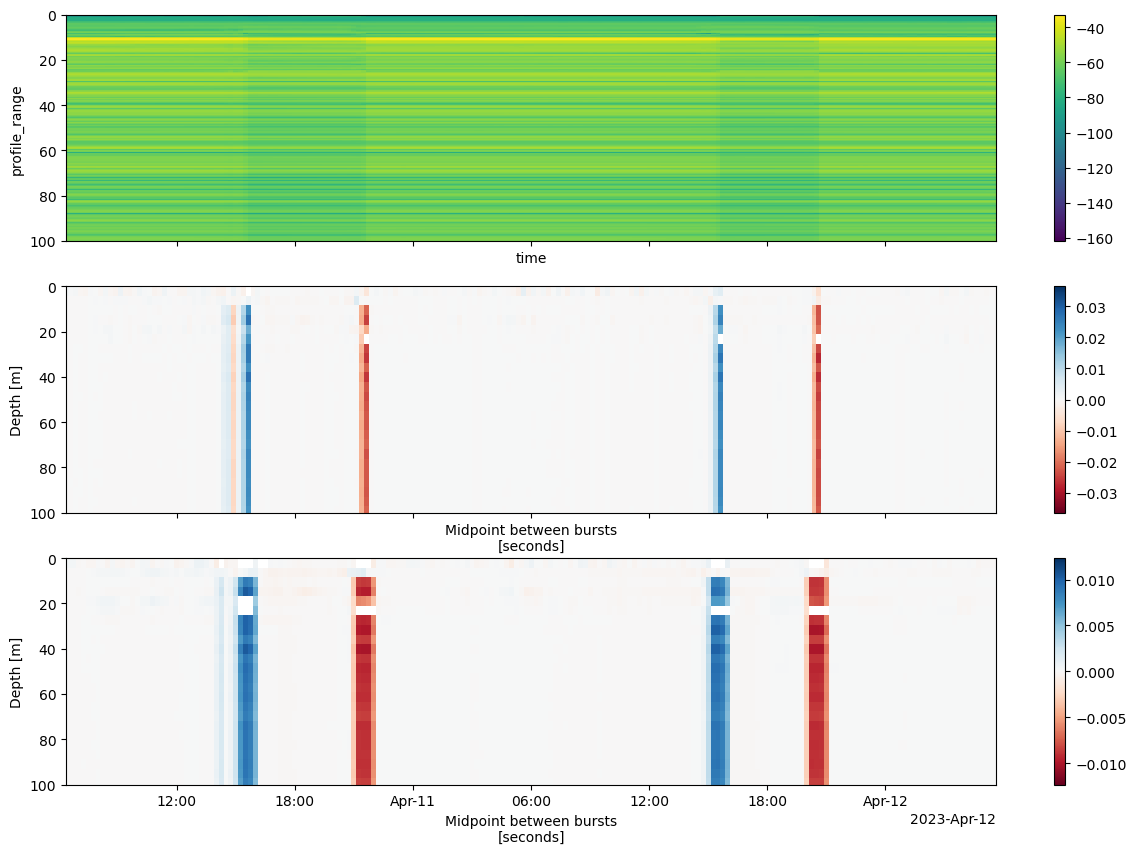

In [26]:
fig, axs = plt.subplots(nrows=3,figsize=(15,10),sharex=True)
xa.dB(interp_profiles).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
axs[0].set_ylim([100,0])
windows = [1,4]
labels = ['15 minutes','1 hour']

for i in range(2):
    count,r2,res = strain_metrics(interp_profiles, 20, 20,windows[i],700)
    disp = res[0]*900/31536000
    disp.plot(ax=axs[1+i],x='time',cmap='RdBu')#,vmin=-10,vmax=10)
    axs[i+1].invert_yaxis()
    axs[i+1].set_ylim([100,0])

Text(0, 0.5, 'depth [m]')

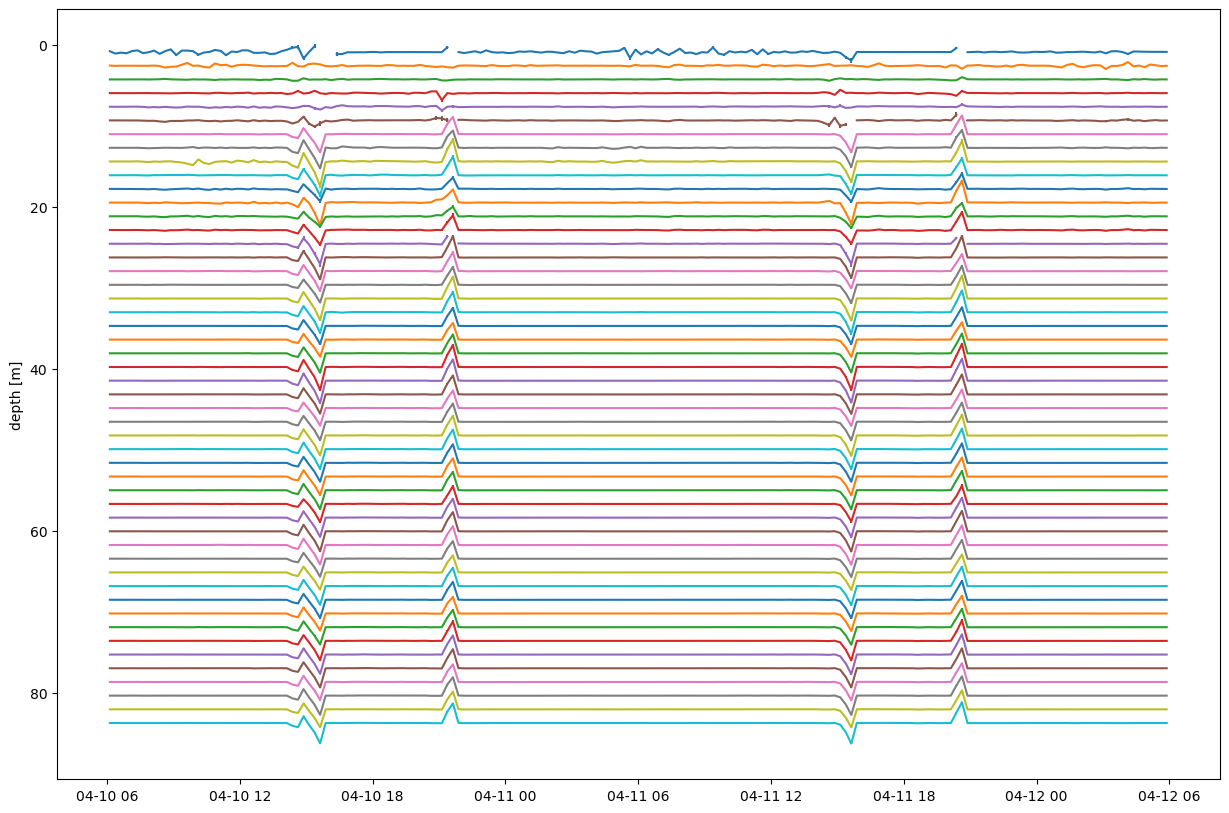

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
count,r2,res = strain_metrics(interp_profiles, 8, 8,1,700)

for i in range(50):
    disp = (res[0]*900/31536000).isel(profile_range=[i])
    disp_err = (res[1]*900/31536000).isel(profile_range=i)*100
    disp_adjust = (disp.profile_range + 100*disp).isel(profile_range = 0)
    ax.errorbar(disp_adjust.time.values,disp_adjust,disp_err)#,linestyle='None',marker='.')
    #(disp.profile_range + 100*disp).plot()
    #disp.plot(ax=axs[1+i],x='time',cmap='RdBu')#,vmin=-10,vmax=10)
ax.invert_yaxis()
ax.set_ylabel('depth [m]')
    #axs[i+1].set_ylim([100,0])

Text(0, 0.5, 'Mean profile amplitude')

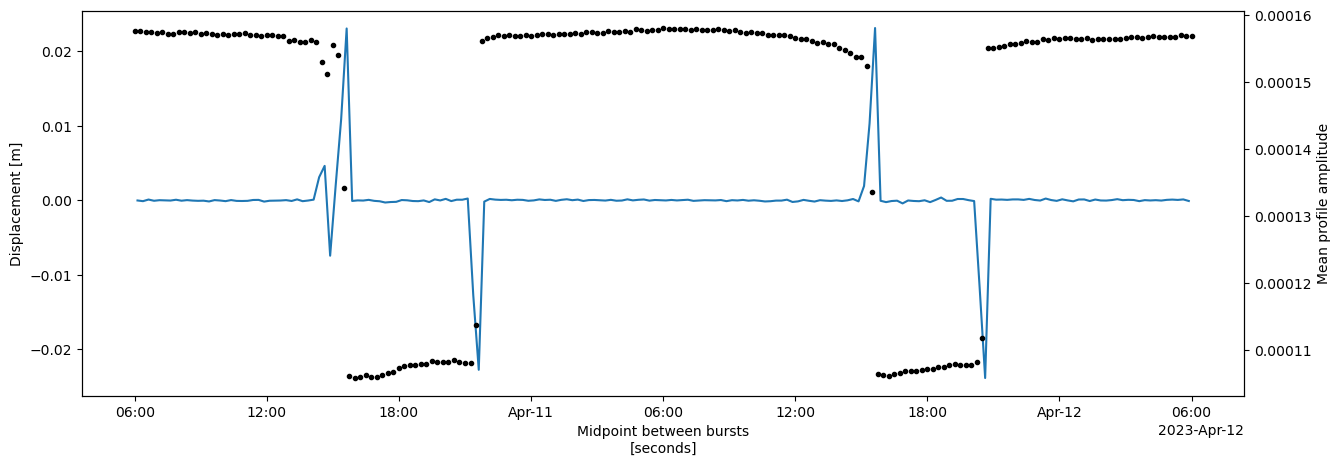

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
count,r2,res = strain_metrics(interp_profiles, 70, 70,1,700)
disp = res[0]*900/31536000
disp.where(disp.profile_range <600).mean(dim='profile_range').plot(ax=ax)
ax1 = ax.twinx()
abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')
ax.set_ylabel('Displacement [m]')
ax1.set_ylabel('Mean profile amplitude')

Text(0.5, 0, 'Mean profile amplitude')

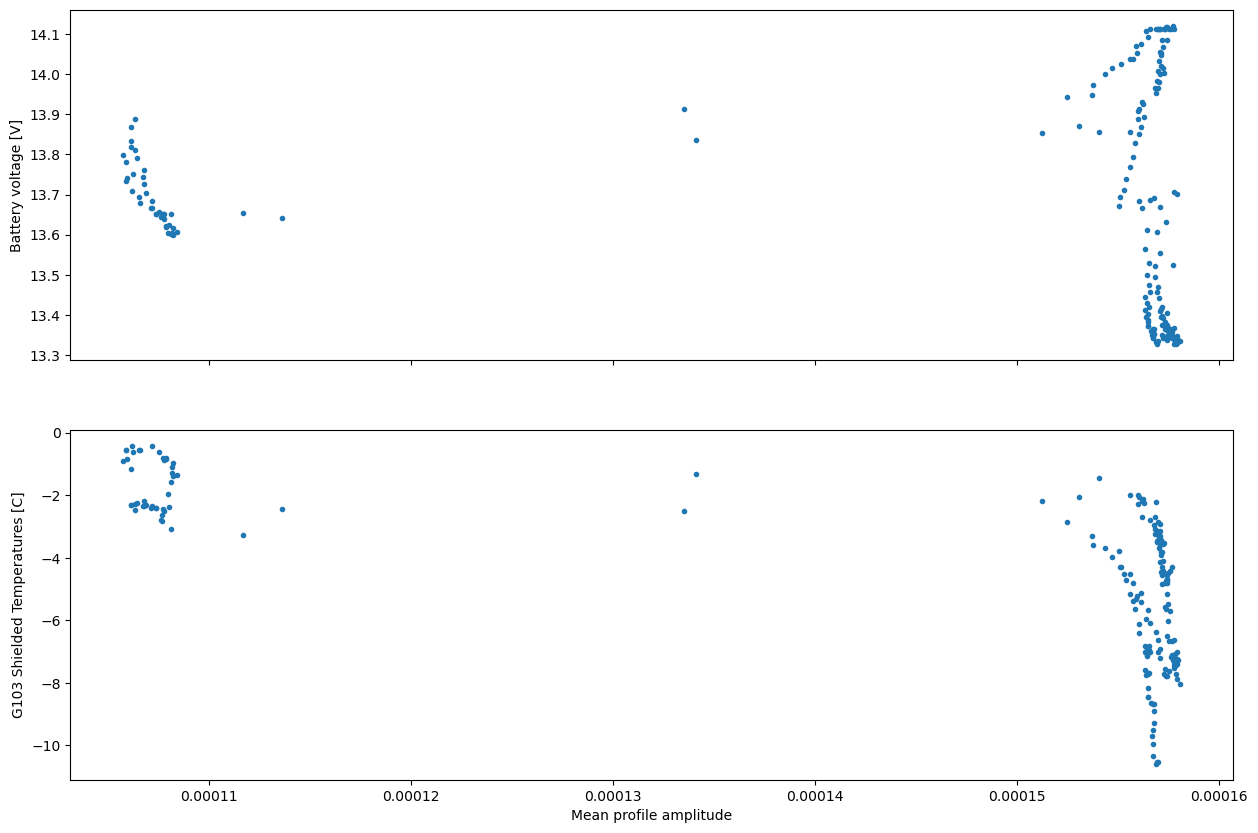

In [21]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)

axs[0].plot(abs(interp_profiles).mean(dim='profile_range').values,voltage.values,linestyle='None',marker='.')
axs[1].plot(abs(interp_profiles).mean(dim='profile_range').values,temperature.values,linestyle='None',marker='.')

axs[0].set_ylabel('Battery voltage [V]')
axs[1].set_ylabel('G103 Shielded Temperatures [C]')
axs[1].set_xlabel('Mean profile amplitude')

Look at small temperature variations

In [28]:
#time_to_interp = pd.date_range("2022-10-20 0:00", "2022-10-30 0:00", freq="15min")
time_to_interp = pd.date_range("2023-03-20 0:00", "2023-03-30 0:00", freq="15min")
#time_to_interp = pd.date_range("2023-03-27 0:00", "2023-03-28 12:00", freq="15min")

interp_profiles = winter.interp(time=time_to_interp,method='linear')


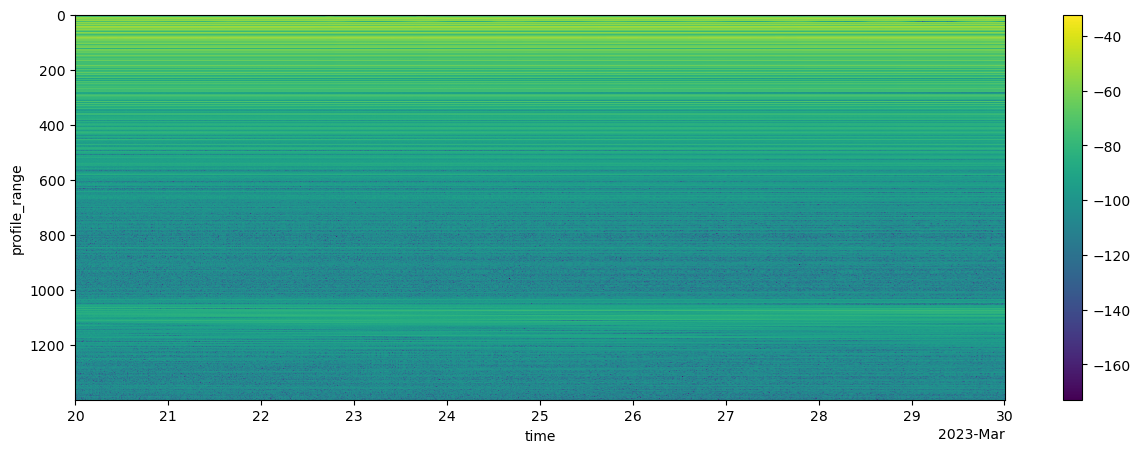

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(interp_profiles).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)

In [30]:
voltage = ds_11_w.battery_voltage.interp(time=time_to_interp,method='linear').compute()
winter_time,winter_temp = load_temp_csv('TS08 2023-05-19 11_07_36.csv')
temperature = xr.DataArray(data=winter_temp,dims=["time"],coords=dict(time=winter_time)).interp(time=time_to_interp,method='linear')

(1.0, -30.0)

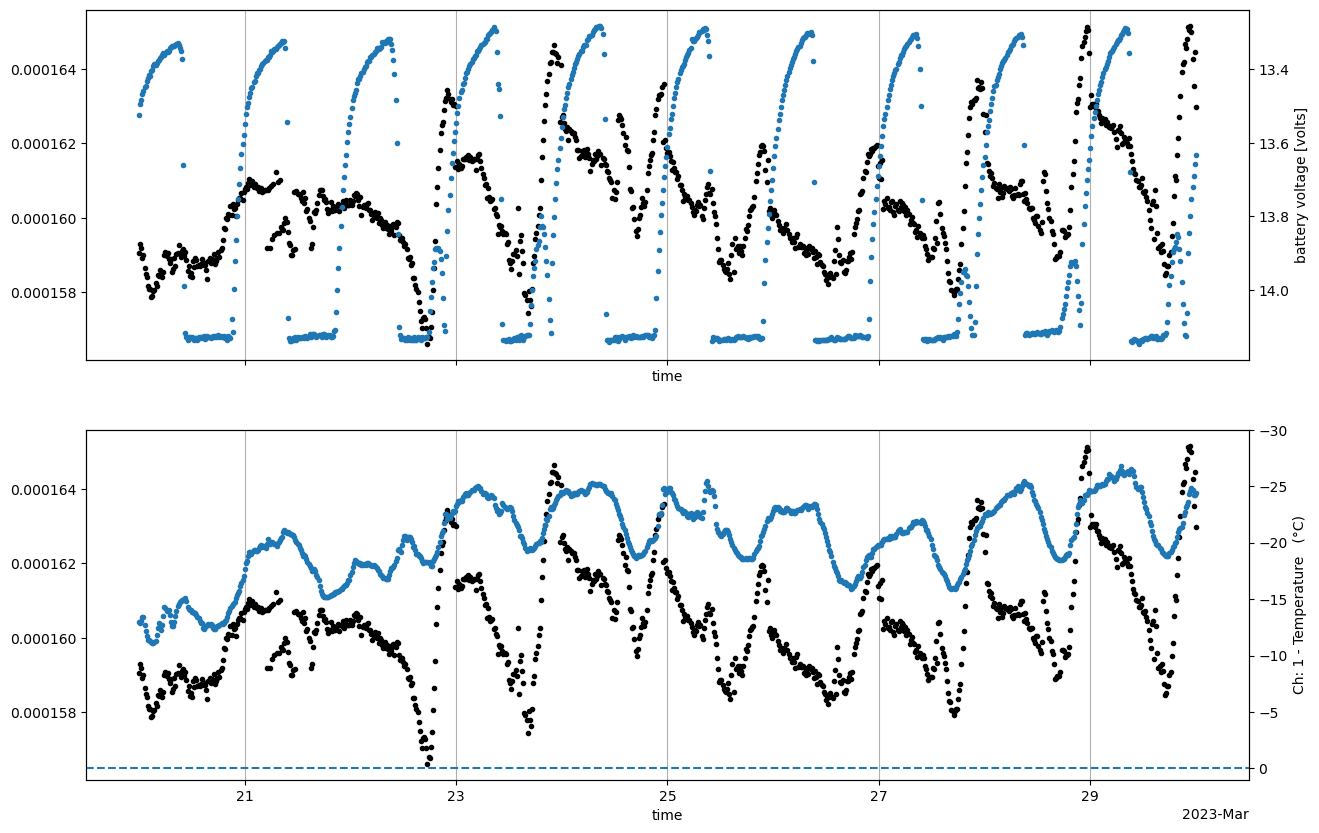

In [37]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
abs(interp_profiles).mean(dim='profile_range').plot(ax=axs[0],color='k',linestyle='None',marker='.')
ax1 = axs[0].twinx()
voltage.plot(ax=ax1,linestyle='None',marker='.')
axs[0].grid(axis = 'x')
ax1.invert_yaxis()

abs(interp_profiles).mean(dim='profile_range').plot(ax=axs[1],color='k',linestyle='None',marker='.')
ax2 = axs[1].twinx()
temperature.plot(ax=ax2,linestyle='None',marker='.')
ax2.axhline(0,linestyle='--')
axs[1].grid(axis = 'x')
ax2.invert_yaxis()
ax2.set_ylim([1,-30])



In [83]:
# Look at chirps
#ds_good = ds_11_w.isel(attenuator_setting_pair=0,chirp_time=range(200,39998),time=range(17080,17140))
ds_good = ds_11_w.isel(attenuator_setting_pair=0,chirp_time=range(200,39998),time=range(17100,17118,4))
chirps_good = ds_good.chirp.compute()


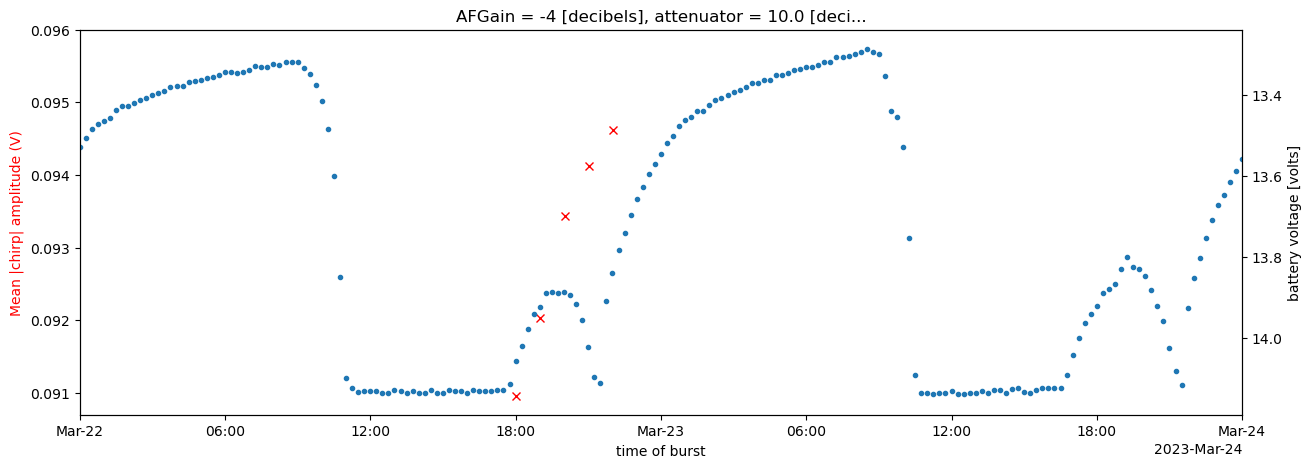

In [103]:
fig, ax = plt.subplots(figsize=(15,5),sharex=True)

abs(chirps_good).mean(dim=['chirp_time','chirp_num']).plot(ax=ax,linestyle='None',marker='x',color='r')
ax.set_ylabel('Mean |chirp| amplitude (V)')
ax.yaxis.label.set_color('red')
ax.set_ylim([0.0907,0.096])
ax1 = ax.twinx()
#abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')
voltage.plot(ax=ax1,linestyle='None',marker='.')
xlim=[date(2023, 3, 22), date(2023, 3, 24)]
ax1.set_xlim(xlim)
ax1.invert_yaxis()


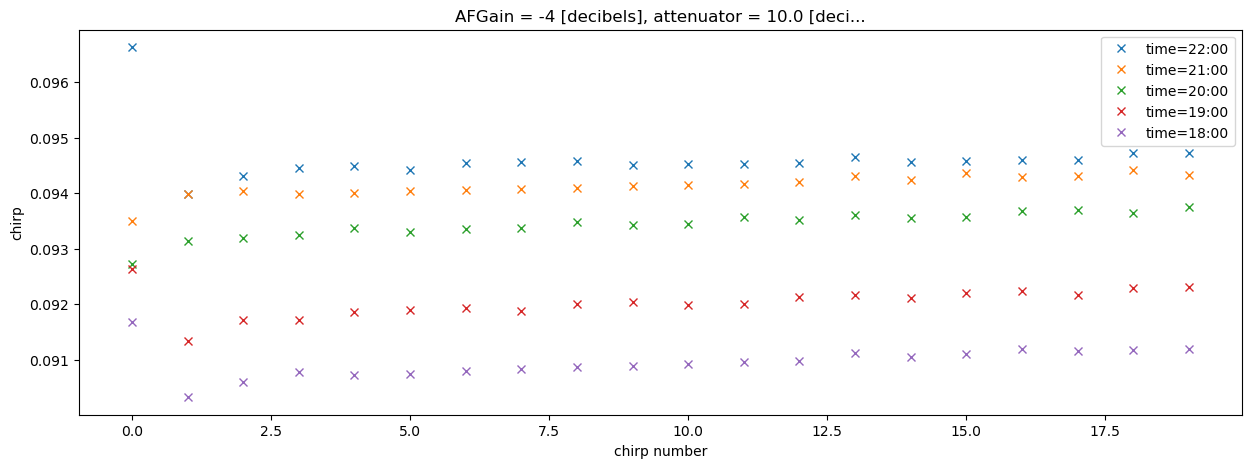

In [101]:
fig, ax = plt.subplots(figsize=(15,5),sharex=True)
for i in reversed(range(len(chirps_good.time.values))):
    abs(chirps_good.isel(time=i)).mean(dim=['chirp_time']).plot(ax=ax,linestyle='None',marker='x',label=f'time={str(chirps_good.time.values[i])[11:15]}0')

ax.legend()


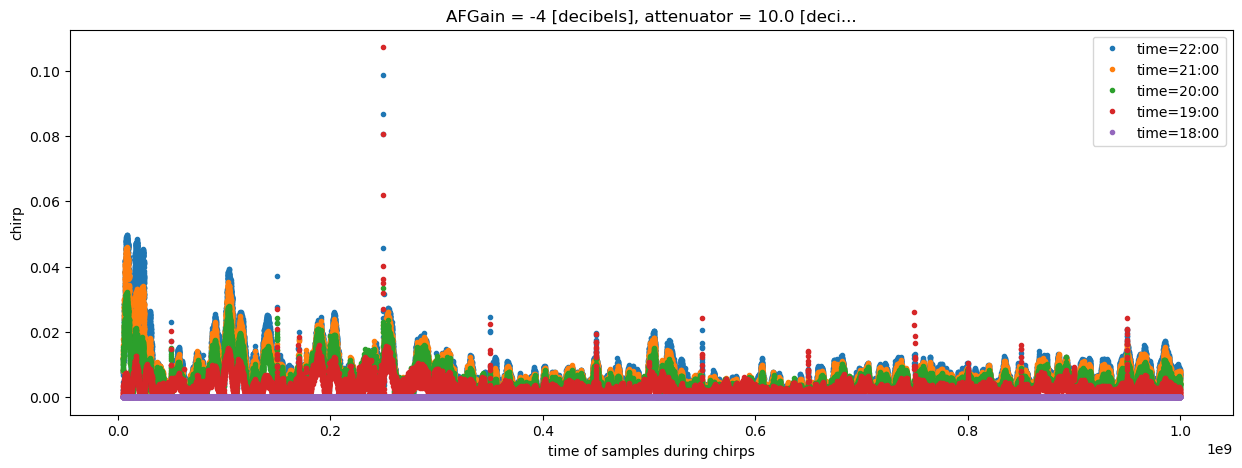

In [100]:
fig, ax = plt.subplots(figsize=(15,5),sharex=True)
for i in reversed(range(len(chirps_good.time.values))):
    abs(chirps_good.isel(time=i).mean(dim=['chirp_num'])-chirps_good.isel(time=0).mean(dim=['chirp_num'])).plot(ax=ax,linestyle='None',marker='.',label=f'time={str(chirps_good.time.values[i])[11:15]}0')

ax.legend()


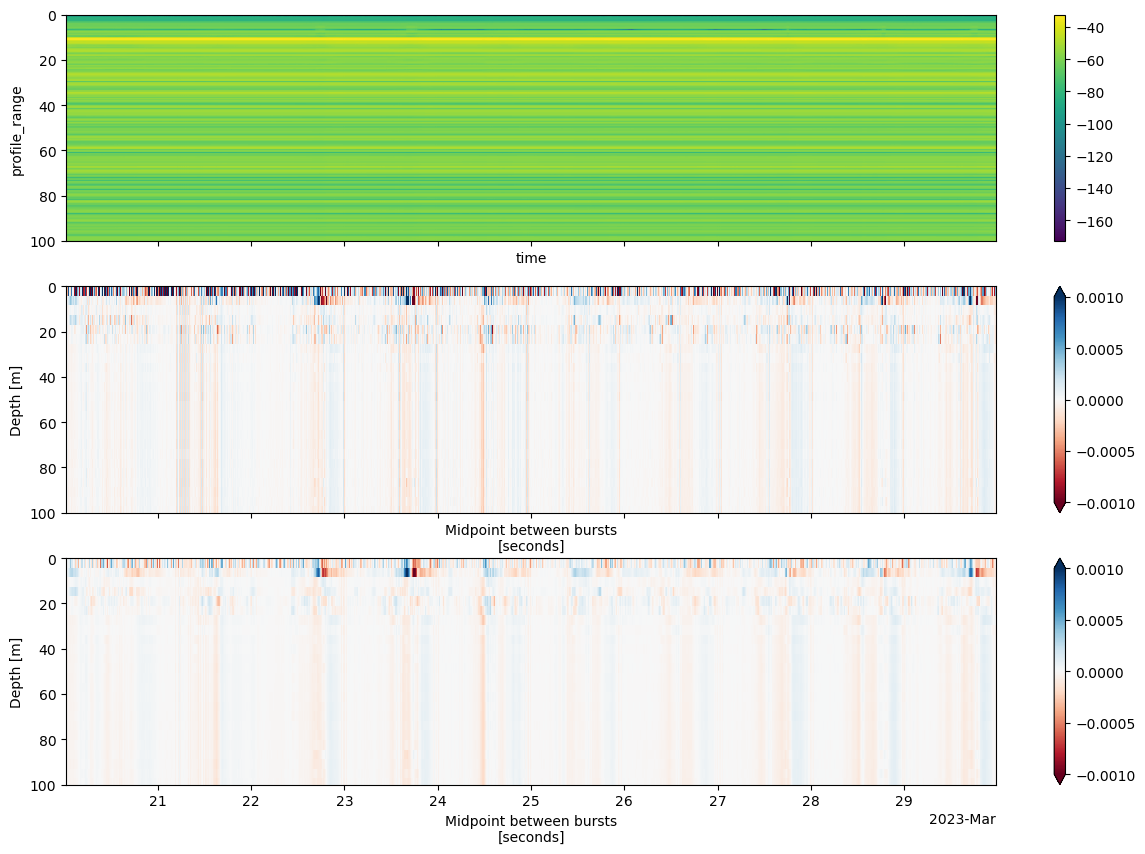

In [32]:
fig, axs = plt.subplots(nrows=3,figsize=(15,10),sharex=True)
xa.dB(interp_profiles).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
axs[0].set_ylim([100,0])
windows = [1,4]
labels = ['15 minutes','1 hour']

for i in range(2):
    count,r2,res = strain_metrics(interp_profiles, 20, 20,windows[i],700)
    disp = res[0]*900/31536000
    disp.plot(ax=axs[1+i],x='time',cmap='RdBu',vmin=-0.001,vmax=0.001)
    axs[i+1].invert_yaxis()
    axs[i+1].set_ylim([100,0])

Text(0, 0.5, 'depth [m]')

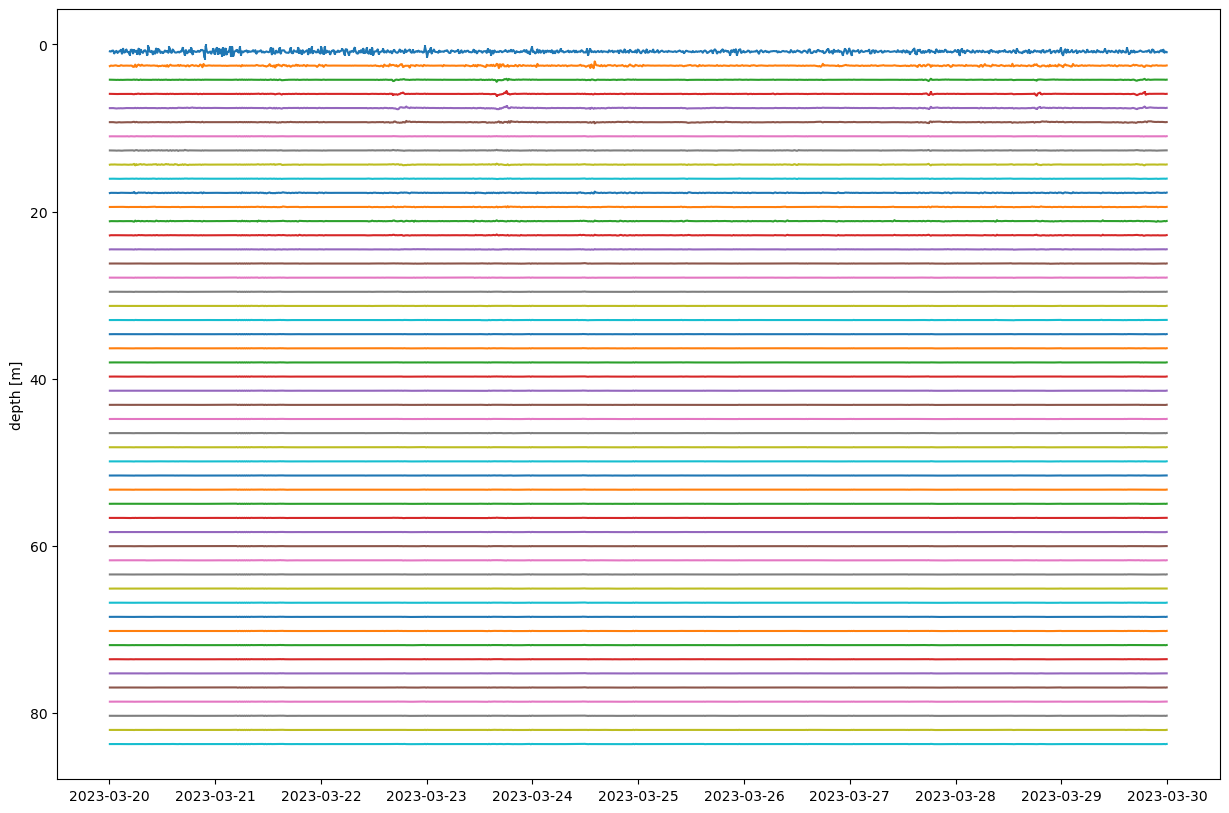

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
count,r2,res = strain_metrics(interp_profiles, 8, 8,1,700)

for i in range(50):
    disp = (res[0]*900/31536000).isel(profile_range=[i])
    disp_err = (res[1]*900/31536000).isel(profile_range=i)*100
    disp_adjust = (disp.profile_range + 100*disp).isel(profile_range = 0)
    ax.errorbar(disp_adjust.time.values,disp_adjust,disp_err)#,linestyle='None',marker='.')
    #(disp.profile_range + 100*disp).plot()
    #disp.plot(ax=axs[1+i],x='time',cmap='RdBu')#,vmin=-10,vmax=10)
ax.invert_yaxis()
ax.set_ylabel('depth [m]')
    #axs[i+1].set_ylim([100,0])

Text(0, 0.5, 'Mean profile amplitude')

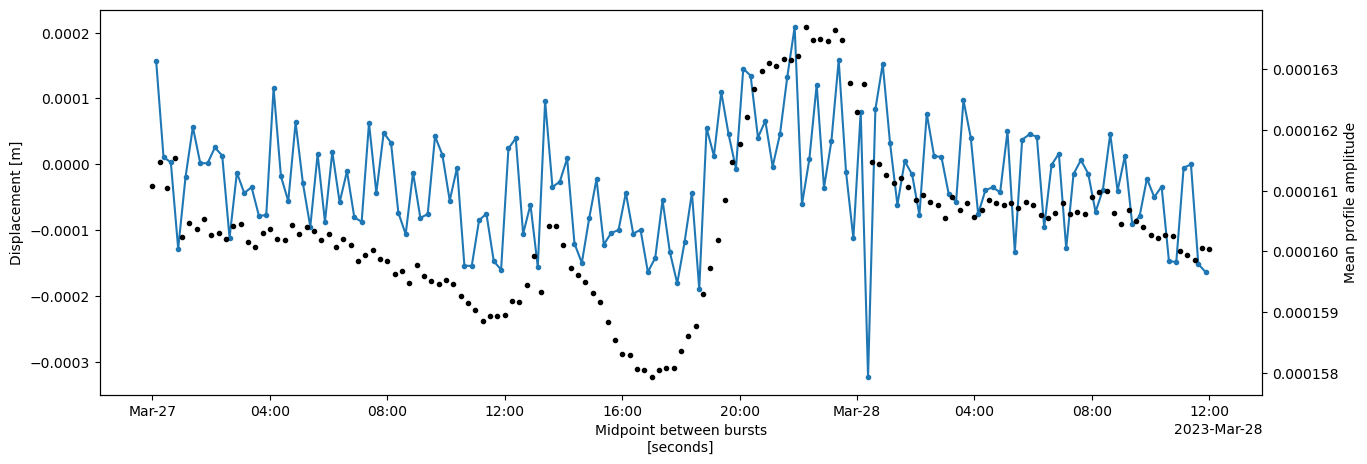

In [73]:
fig, ax = plt.subplots(figsize=(15,5))
count,r2,res = strain_metrics(interp_profiles, 70, 70,1,700)
disp = res[0]*900/31536000
disp.where(disp.profile_range <600).mean(dim='profile_range').plot(ax=ax,marker='.')
ax1 = ax.twinx()
abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')
ax.set_ylabel('Displacement [m]')
ax1.set_ylabel('Mean profile amplitude')

Let's try with clean snippet

In [26]:
time_to_interp = pd.date_range("2023-01-02 0:00", "2023-01-03 0:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')


(200.0, 0.0)

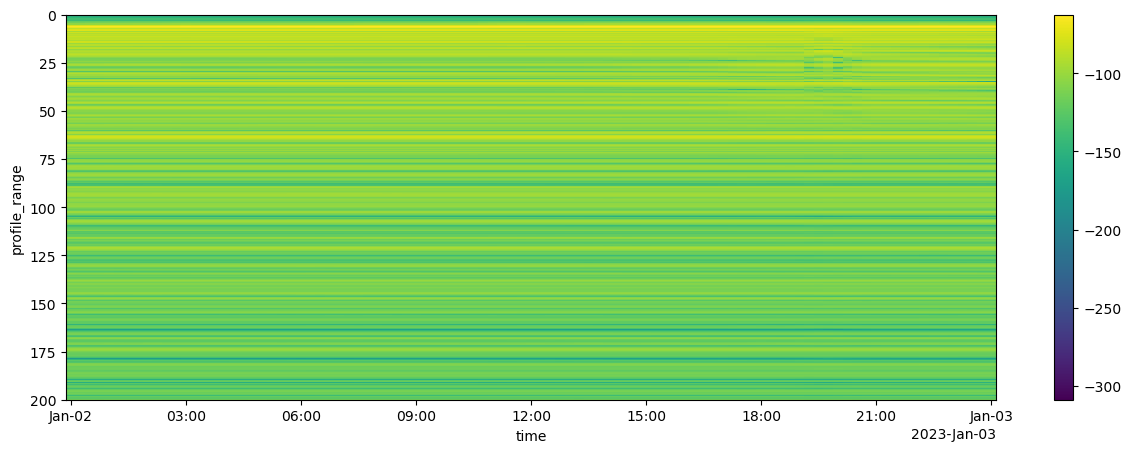

In [52]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(abs(interp_profiles)**2).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)
plt.ylim([200,0])

Text(0.5, 1.0, 'Phase')

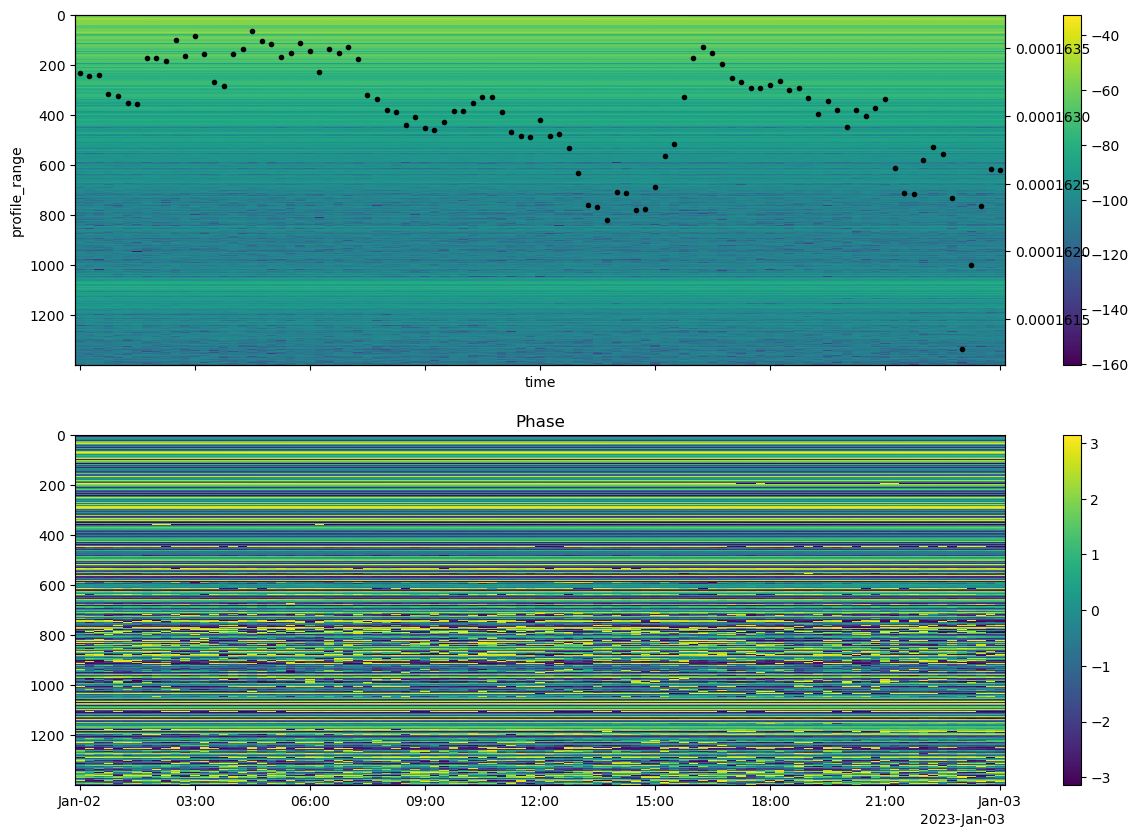

In [119]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
fg=xa.dB(interp_profiles).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
ax1 = axs[0].twinx()
abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')

phi = -np.angle(interp_profiles).astype(float)
im = axs[1].pcolormesh(interp_profiles.time.values,interp_profiles.profile_range.values,phi.T)
axs[1].invert_yaxis()
fig.colorbar(im)
axs[1].set_title('Phase')

In [27]:
voltage = ds_11_w.battery_voltage.interp(time=time_to_interp,method='linear').compute()
winter_time,winter_temp = load_temp_csv('TS08 2023-05-19 11_07_36.csv')
temperature = xr.DataArray(data=winter_temp,dims=["time"],coords=dict(time=winter_time)).interp(time=time_to_interp,method='linear')

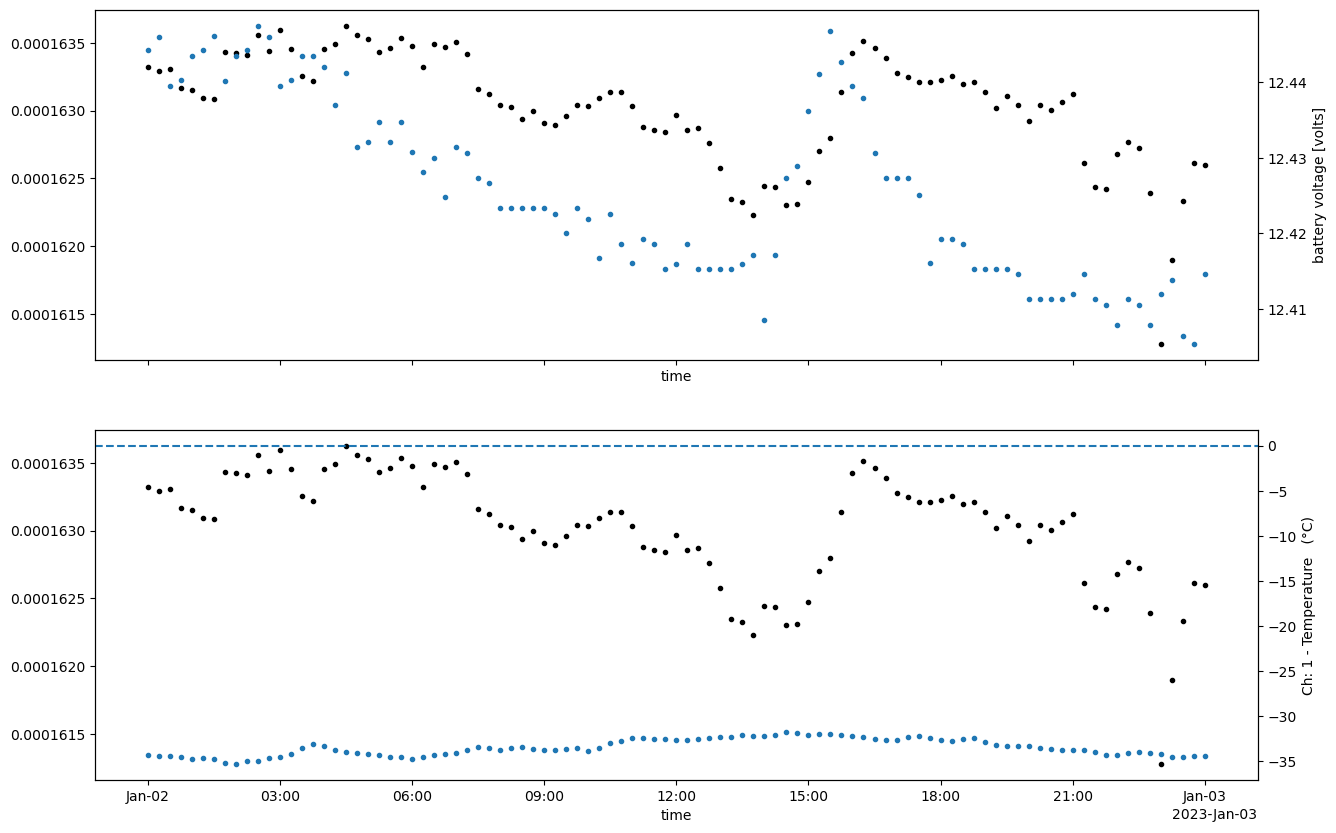

In [28]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
abs(interp_profiles).mean(dim='profile_range').plot(ax=axs[0],color='k',linestyle='None',marker='.')
ax1 = axs[0].twinx()
voltage.plot(ax=ax1,linestyle='None',marker='.')

abs(interp_profiles).mean(dim='profile_range').plot(ax=axs[1],color='k',linestyle='None',marker='.')
ax2 = axs[1].twinx()
temperature.plot(ax=ax2,linestyle='None',marker='.')
ax2.axhline(0,linestyle='--')



In [29]:
from scipy.stats import linregress
amps = abs(interp_profiles).mean(dim='profile_range').values
ret_v = linregress(amps,voltage.values)
ret_t = linregress(amps,temperature.values)


In [30]:
ret_v

LinregressResult(slope=16622.247710971737, intercept=9.715555897008937, rvalue=0.5819469640443053, pvalue=4.0626455861258774e-10, stderr=2383.176408437434, intercept_stderr=0.3885190502194741)

Text(0.5, 0, 'Mean profile amplitude')

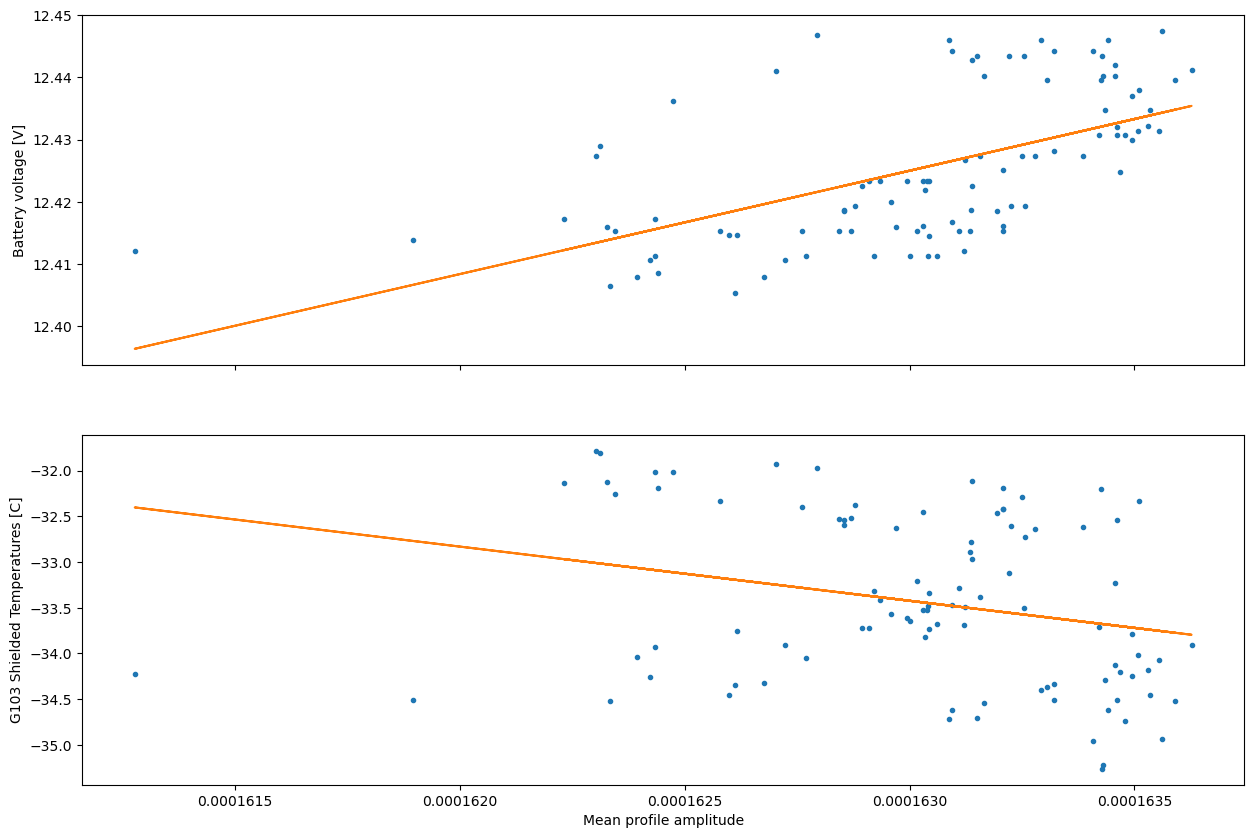

In [31]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)

axs[0].plot(amps,voltage.values,linestyle='None',marker='.')
axs[0].plot(amps,ret_v.slope*amps+ret_v.intercept)

axs[1].plot(amps,temperature.values,linestyle='None',marker='.')
axs[1].plot(amps,ret_t.slope*amps+ret_t.intercept)


axs[0].set_ylabel('Battery voltage [V]')
axs[1].set_ylabel('G103 Shielded Temperatures [C]')
axs[1].set_xlabel('Mean profile amplitude')

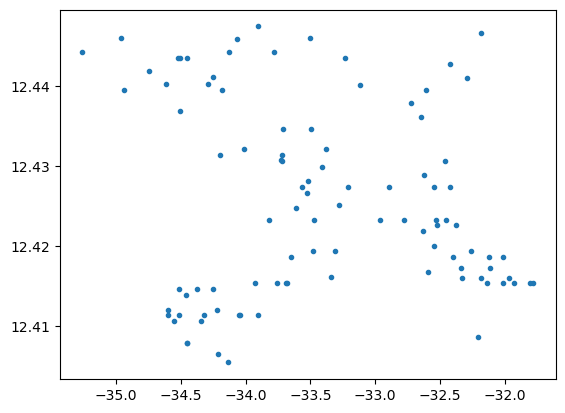

In [28]:
ret_vt = linregress(temperature.values,voltage.values)
plt.plot(temperature.values,voltage.values,linestyle='None',marker='.')

In [122]:
time_to_interp_good = pd.date_range("2023-01-02 0:00", "2023-01-03 0:00", freq="15min")
ds_good = ds_11_w.isel(attenuator_setting_pair=0,chirp_time=range(200,39998)).interp(time=time_to_interp_good,method='linear')
chirps_good = ds_good.chirp.compute()


In [123]:
clip_threshold = 1.2
min_chirps = 5
bad_chirps =  chirps_good.where(abs(chirps_good) > clip_threshold)
good_bursts = bad_chirps.max(dim='chirp_time').count(dim='chirp_num') <= 20-min_chirps
chirps = chirps_good.where(good_bursts)
chirps = chirps.where(abs(chirps).max(dim='chirp_time')<clip_threshold)

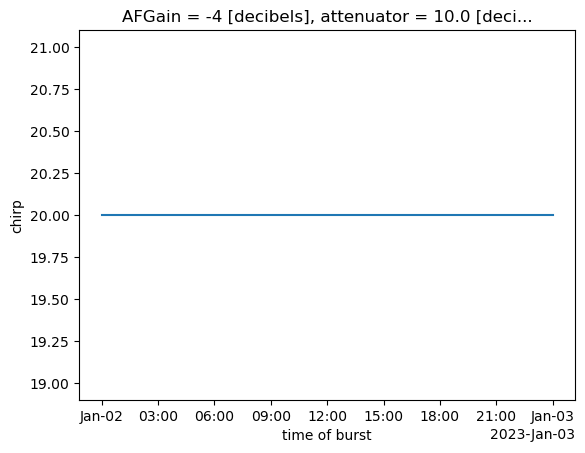

In [124]:
chirps.mean(dim='chirp_time').count(dim='chirp_num').plot()

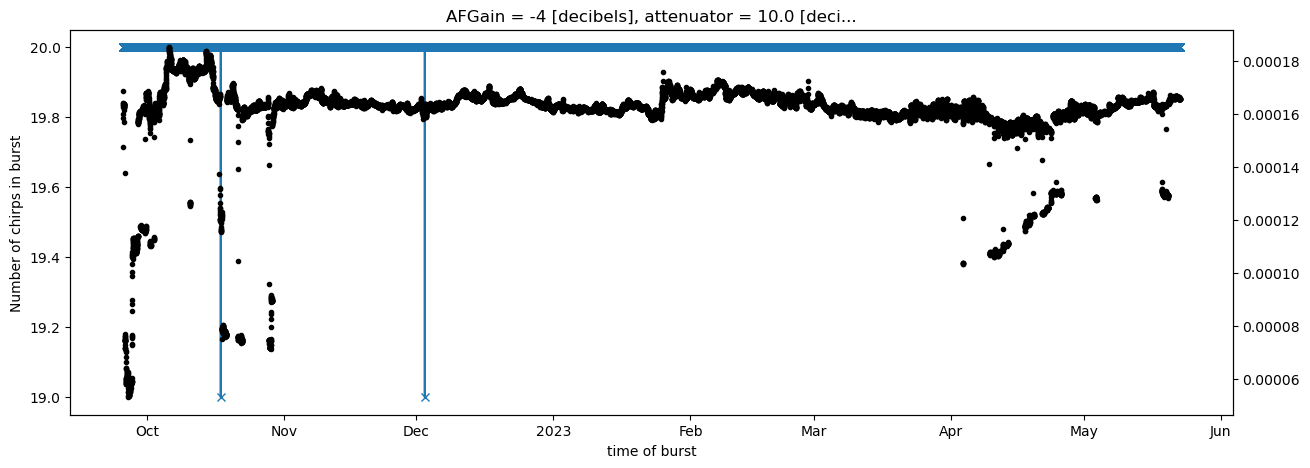

In [138]:
fig, axs = plt.subplots(nrows=1,figsize=(15,5),sharex=True)

to_plot.plot(ax=axs,marker='x')
#axs.set_xlim([date(2022, 12, 2), date(2022, 12, 4)])
axs.set_ylabel('Number of chirps in burst')
#time_to_interp = pd.date_range("2022-12-02 0:00", "2022-12-04 0:00", freq="15min")
#interp_profiles = winter.interp(time=time_to_interp,method='linear')
ax1=axs.twinx()
ax1.set_ylabel('Mean profile amplitude')
#abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')
abs(winter).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')


Text(0.5, 0, 'chirp time [ns]')

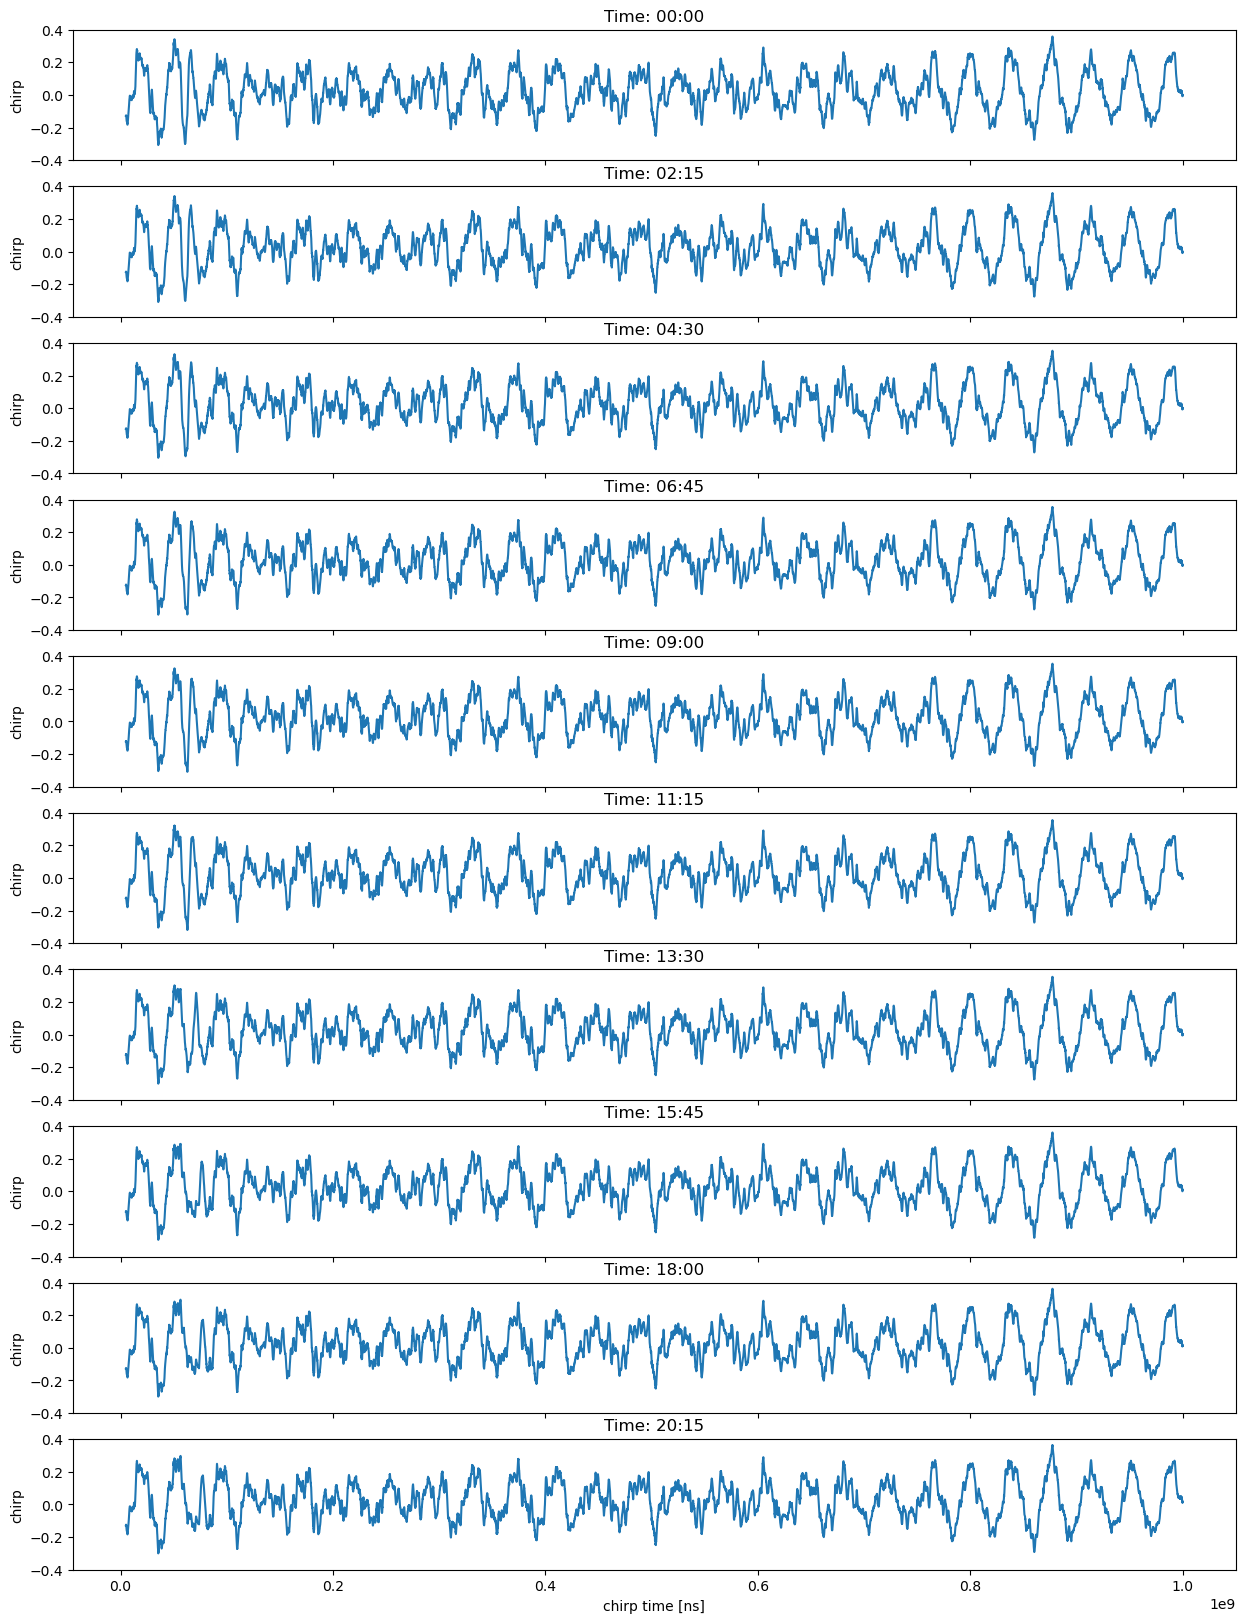

In [129]:
fig, axs = plt.subplots(nrows=10,figsize=(15,20),sharex=True)
for i in range(10):
    chirp = chirps_good.isel(time= [i*9]).mean(dim='chirp_num')
    chirp.plot(ax=axs[i])
    axs[i].set_title(f'Time: {str(chirp.time.values[0])[11:16]}')
    axs[i].set_xlabel('')
    axs[i].set_ylim([-0.4,0.4])
axs[-1].set_xlabel('chirp time [ns]')


Text(0.5, 0, 'chirp number [ns]')

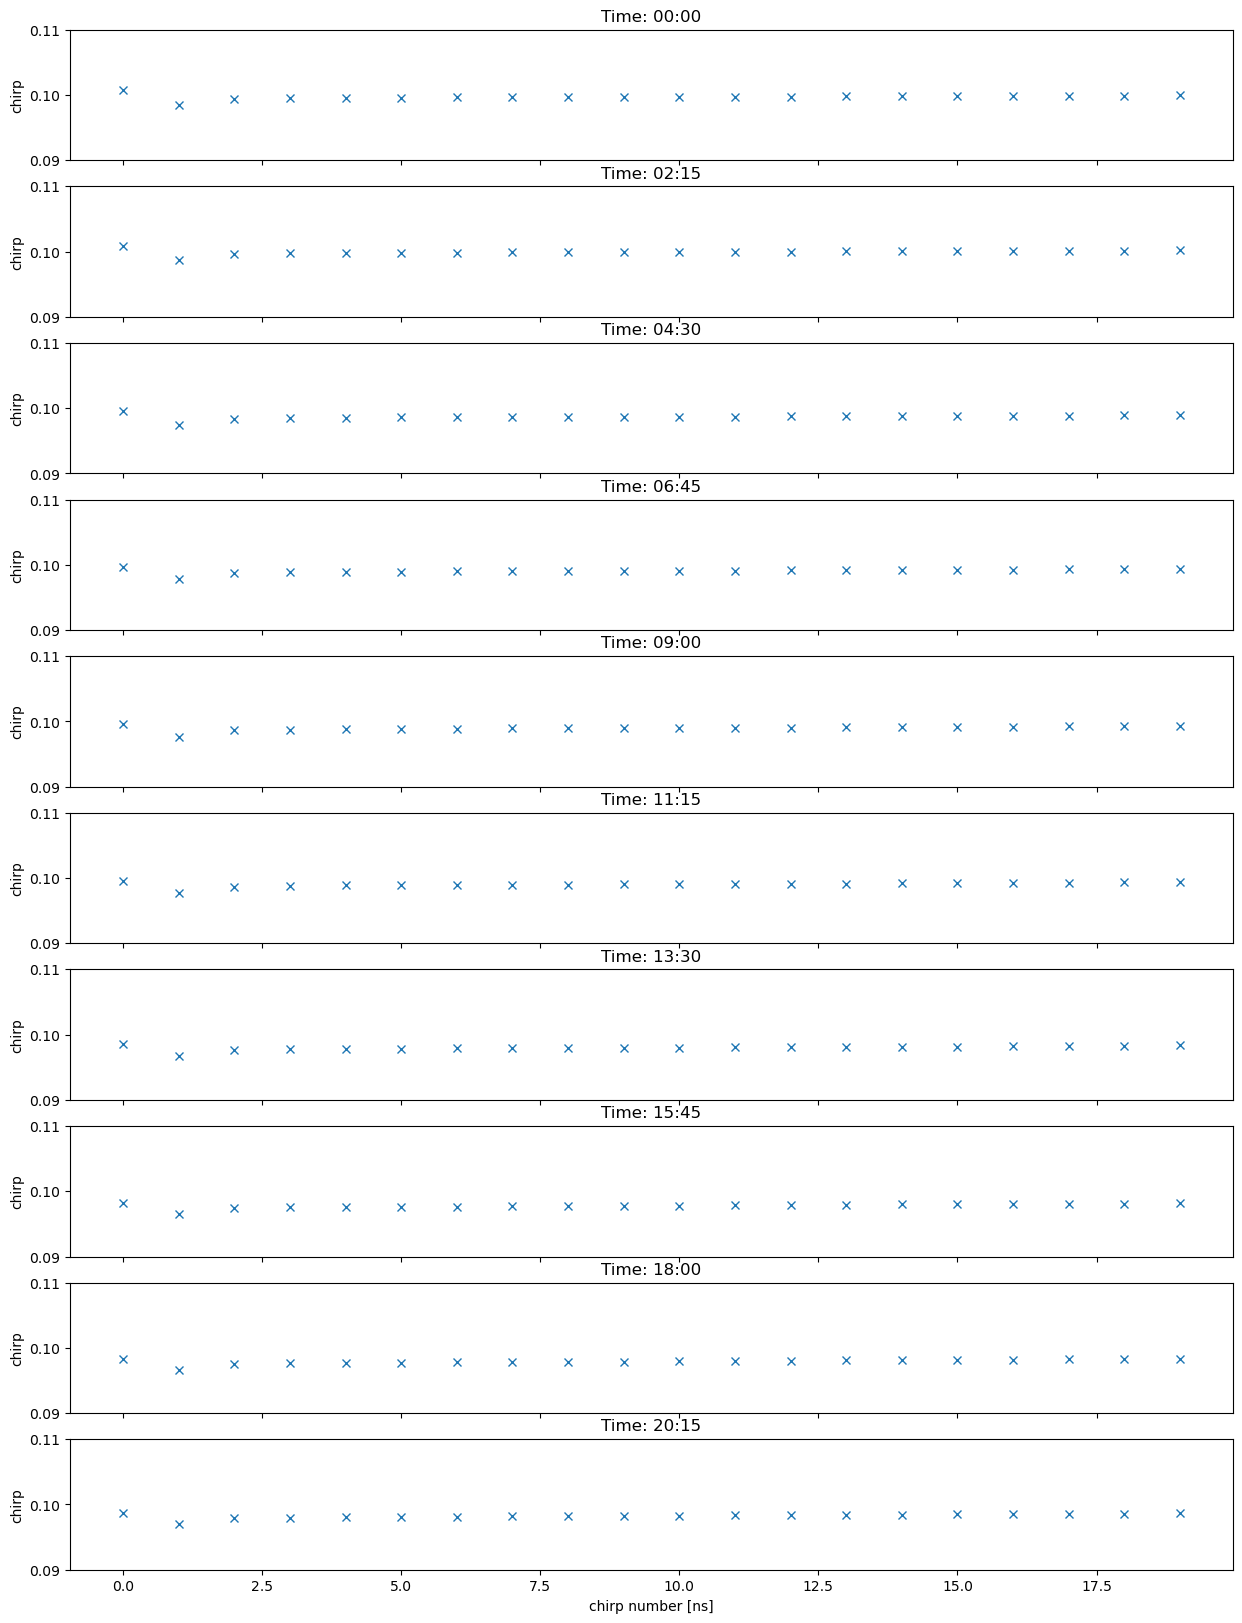

In [130]:
fig, axs = plt.subplots(nrows=10,figsize=(15,20),sharex=True)
for i in range(10):
    chirp = abs(chirps_good.isel(time= [i*9])).mean(dim='chirp_time')
    chirp.plot(ax=axs[i],linestyle='None',marker='x')
    axs[i].set_title(f'Time: {str(chirp.time.values[0])[11:16]}')
    axs[i].set_xlabel('')
    axs[i].set_ylim([0.09,0.11])
axs[-1].set_xlabel('chirp number [ns]')


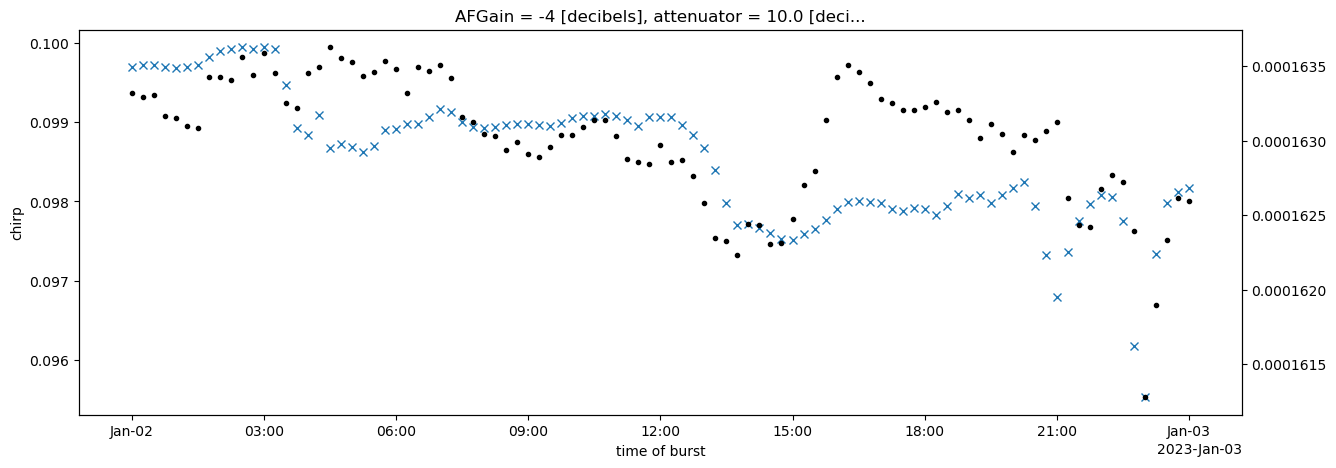

In [132]:
fig, axs = plt.subplots(nrows=1,figsize=(15,5),sharex=True)

abs(chirps_good).mean(dim=['chirp_time','chirp_num']).plot(ax=axs,linestyle='None',marker='x',label='mean chirp amplitude')
ax1=axs.twinx()
abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.',label='mean profile amplitude')